2018 Edition

# Estimating Financial Risk through Monte Carlo Simulation
Risk analysis is part of every decision we make when faced with uncertainty, ambiguity, and variability. Indeed, even though we have unprecedented access to information, we can't accurately predict the future. In finance, there is a fair amount of uncertainty and risk involved with estimating the future value of financial products, due to the wide variety of potential outcomes. Monte Carlo simulation (also known as the Monte Carlo Method) allows inspecting many possible outcomes of the decision making process, and can be used to assess the impact of risk: this, in turns, allows for better decision-making under uncertainty.

## Goals
The main objectives we set for this Notebook are as follows:
1. Develop fundamental knowledge about Risk analysis
2. Understand Monte Carlo Simulation (MCS)
3. Apply Monte Carlo Simulation for predicting risk


## Steps
1. First, in section 1, we introduce the basics of MCS
2. In section 2, we work on a simple example to where we apply the MCS method
3. In section 3, we briefly summarize the main characteristics of the Monte Carlo Simulation (MCS) technique
4. In section 4, we overview the common distributions which are often used in MCS
5. In section 5, we work on a real use case, that focuses on estimating financial risk. We will use techniques such as featurization  (that is, generating additional features to improve model accuracy), linear regression, kernel density estimation, sampling distributions and so on ...

## Reference
This Notebook is inspired by Chapter 9 of the book [Advanced Analytics with Spark](http://shop.oreilly.com/product/0636920035091.do) by Josh Wills, Sandy Ryza, Sean Owen, and Uri Laserson. It is strongly suggested to read this Chapter to get a general idea of the topic of this Notebook.

# 1. Introduction

## 1.1. Monte Carlo Simulation (MCS)
Monte Carlo simulation is a computerized mathematical technique that can be applied such that it is possible to account for risk in quantitative analysis and decision making. This technique is used in many different fields, such as R&D, risk management, portfolio management, pricing derivatives, strategic planning, project planning, cost modeling and many more.

In general, MCS is a technique that "converts" uncertainty on input variables of a model into **probability distributions**. By combining the distributions and randomly selecting values from them, it recalculates the simulated model many times, to determine the probability of the output.

Historically, this technique was first used by scientists working on the atomic bomb: it was named after Monte Carlo, the Monaco resort town renowned for its casinos.  Since its introduction in World War II, Monte Carlo simulation has been used to model a variety of physical and conceptual systems.

## 1.2. How does it work?
Monte Carlo simulation performs risk analysis by building models of possible results by *substituting a range of possible input values, that constitute uncertainty, into a statistical distribution*. It then computes possible outcomes repeatedly, each time using a different set of random values from the probability functions that "model" the input. Depending upon the number of random input variables and their distribution, a Monte Carlo simulation could involve thousands or tens of thousands of "rounds" before it is complete. When complete, *Monte Carlo simulation produces distributions of possible outcome values*.

By using probability distributions instead of actual input samples, it is possible to model more accurately uncertainty: different choices of distributions will yield different outputs.

# 2. Illustrative example

Imagine you are the marketing manager for a firm that is planning to introduce a new product. You need to estimate the first-year net profit from this product, which might depend on:

- Sales volume in units
- Price per unit (also called "Selling price")
- Unit cost
- Fixed costs

Net profit will be calculated as $Net Profit = Sales Volume* (Selling Price - Unit cost) - Fixed costs$.  Fixed costs (accounting for various overheads, advertising budget, etc.) are known to be \$ 120,000, which we assume to be deterministic. All other factors, instead, involve some uncertainty: *sales volume* (in units) can cover quite a large range, the *selling price* per unit will depend on competitor actions, which are hard to predict, and *unit costs* will also vary depending on vendor prices and production experience, for example.

Now, to build a risk analysis model, we must first identify the uncertain variables -- which are essentially random variables.  While there's some uncertainty in almost all variables in a business model, we want to focus on variables where the range of values is significant.

## 2.1. Unit sales and unit price

Based on a hypothetical market research you have done, you have beliefs that there are equal chances for the market to be `slow`, `normal`, or `hot`:

- In a "slow" market, you expect to sell 50,000 units at an average selling price of \$11.00 per unit
- In a "normal" market, you expect to sell 75,000 units, but you'll likely realize a lower average selling price of \$10.00 per unit
- In a "hot" market, you expect to sell 100,000 units, but this will bring in competitors, who will drive down the average selling price to \$8.00 per unit

In [276]:
import numpy as np
from datetime import datetime
from datetime import timedelta
from itertools import islice
%matplotlib inline
import statsmodels.api as sm
import pandas as pd
import math
import pylab 
import scipy.stats as stats
import matplotlib.mlab as mlab

### Question 1
<div class="alert alert-info">
Calculate the average units and the unit price that you expect to sell, which depend on the market state. Use the assumptions above to compute the expected quantity of products and their expected unit price. 
</div>


In [277]:
market_scenario_price = np.array([[0, 50000, 11.0], [1, 75000, 10.0], [2, 100000, 8.0]])
average_unit = np.mean(market_scenario_price[:,1])
average_price = np.mean(market_scenario_price[:,2])
print("average unit:", average_unit)
print("average_price:", average_price)


average unit: 75000.0
average_price: 9.666666666666666


## 2.2. Unit Cost

Another uncertain variable is Unit Cost. In our illustrative example, we assume that your firm's production manager advises you that unit costs may be anywhere from \$5.50 to \$7.50, with a most likely expected cost of \$6.50. In this case, the most likely cost can be considered as the average cost.

## 2.3. A Flawed Model: using averages to represent our random variables
Our next step is to identify uncertain functions -- also called functions of a random variable.  Recall that Net Profit is calculated as $Net Profit = Sales Volume * (Selling Price - Unit cost) - Fixed costs$.  However, Sales Volume, Selling Price and Unit Cost are all uncertain variables, so Net Profit is an uncertain function.

The simplest model to predict the Net Profit is using average of sales volume, average of selling price and average of unit cost for calculating. So, if only consider averages, we can say that the $Net Profit = 75,000*(9.66666666 - 6.5) - 120,000 \sim 117,500$.

However, as [Dr. Sam Savage](http://web.stanford.edu/~savage/faculty/savage/) warns, "Plans based on average assumptions will be wrong on average." The calculated result is far from the actual value: indeed, the **true average Net Profit** is roughly  \$93,000, as we will see later in the example.

### Question 2
#### Question 2.1
<div class="alert alert-info">
Write a function named `calNetProfit` to calculate the Net Profit using the average of sales volume, the average of selling price and the average of unit cost.
</div>

In [278]:
def calNetProfit(average_unit, average_price, average_unitcost, fixed_cost):
    return average_unit * (average_price - average_unitcost) - fixed_cost

average_unitcost = 6.5
fixed_cost = 120000
NetProfit = calNetProfit(average_unit, average_price, average_unitcost, fixed_cost)
print("Net profit:", NetProfit)


Net profit: 117499.99999999994


#### Question 2.2
<div class="alert alert-info">
Verify the warning message of Dr. Sam Savage by calculating the error of our estimated Net Profit using averages only. Recall that the true value is roughly \$93,000, so we are interested in:
<ul></ul>

$$ error = \frac{your\_value - true\_value}{true\_value}$$

<ul></ul>
Note also we are interested in displaying the error as a percentage.
<ul></ul>
Looking at the error we make, do you think that we can use the current model that only relies on averages?
</div>

In [279]:
trueNetProfit = 93000
def compute_rel_error(NetProfit):
    error = (NetProfit - trueNetProfit) / (trueNetProfit)
    return abs(error)

error = compute_rel_error(NetProfit)
print("Error in percentage:", error * 100)


Error in percentage: 26.344086021505316


<div class="alert alert-warning">
<div class="label label-success">INFERENCE:</div><br>
The absolute error is the magnitude of the difference between the exact value and the approximation (NetProfit - trueNetProfit ~ 24500). 
<br>The relative error is the absolute error divided by the magnitude of the exact value.
<br>The error percentage seems to be huge. Our computed value is over 25% more than the true value of net profit. 
<br>We, obviously, can't rely on this model!
</div>

## 2.4. Using the Monte Carlo Simulation method to improve our model
As discussed before, the selling price and selling volume both depend on the state of the market scenario (slow/normal/hot). So, the net profit is the result of two random variables: `market scenario` (which in turn determines `sales volumes` and `selling price`) and `unit cost`.

Now, let's assume (this is an *a-priori* assumption we make) that `market scenario` follows a discrete, uniform distribution and that `unit cost` also follows a uniform distribution. Then, we can compute directly the values for selling price and selling volumes based on the outcome of the random variable `market scenario`, as shown in Section 2.1.

From these a-priori distributions, in each run (or trial) of our Monte Carlo simulation, we can generate the sample value for each random variable and use it to calculate the Net Profit. The more simulation runs, the more accurate our results will be. For example, if we run the simulation 100,000 times, the average net profit will amount to roughly \$92,600. Every time we run the simulation, a different prediction will be output: the average of such predictions will consistently be less than \$117,500, which we predicted using averages only.

Note also that in this simple example, we generate values for the `market scenario` and `unit cost` independently: we consider them to be **independent random variables**. This means that the eventual (and realistic!) correlation between the `market scenario` and `unit cost` variables is ignored. Later, we will learn how to be more precise and account for dependency between random variables.


### Question 3
#### Question 3.1
<div class="alert alert-info">
Write a function named `get_sales_volume_price` that returns the sales volume and price based on the market scenario. In particular, the scenario can get one of three values:
<ul>
  <li>0: Slow market</li>
  <li>1: Normal market</li>
  <li>2: Hot market</li>
</ul>  

The return value is a tuple in the form: `(sales_volume, price)`
</div>

In [280]:
# Get sales volume and  price based on market scenario
# the function returns a tuple of (sales_volume, price)
def get_sales_volume_price(scenario):
    # Slow market
    if scenario == 0:
        return (market_scenario_price[0][1], market_scenario_price[0][2])
    # Normal market
    if scenario == 1:
        return (market_scenario_price[1][1], market_scenario_price[1][2])
    # Hot market
    if scenario == 2:
        return (market_scenario_price[2][1], market_scenario_price[2][2])


#### Question 3.2
<div class="alert alert-info">
Run 100,000 Monte Carlo simulations and calculate the average net profit they produce. Then, compare the result to the "average model" we used in the previous questions (the one we called "flawed" model). Put your comments about the discrepancies between a simplistic model, and the more accurate MCS approach.  
<ul></ul>
Note that in each iteration, the `unit_cost` and `market_scenario` are generated according to their distributions. Also, recall what we have seen in Section 2.2: your firm account manager helped you with some research, to determine the variability of your random variables.  
</div>


<div class="label label-success">HINT</div>  

Function `uniform(a,b)` in module `random` generates a number $a<=c<=b$, which is drawn from a uniform distribution.  

Function `randint(a,b)` helps you generating an integer number $a<=c<=b$

In [336]:
import random

total = 0.0
num_simulation = 100000
for i in range(0,num_simulation):
    unit_cost = np.random.uniform(5.5, 7.5)
    #print('unit cost = ', unit_cost)
    market_scenario = np.random.randint(0, 3)
    #print('ms = ', market_scenario)
    sales_volume, price = get_sales_volume_price(market_scenario)
    #print('sales_volume', sales_volume, 'price: ', price)
    netProfit = calNetProfit(sales_volume, price, unit_cost, fixed_cost)
    total += netProfit

print("average net profit:", total/num_simulation)
error = compute_rel_error(total/num_simulation)
print("Absolute value of relative error in percentage:", error * 100)


average net profit: 92309.97097630653
Absolute value of relative error in percentage: 0.741966692143513


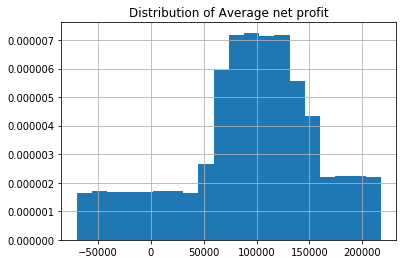

In [340]:
plt.title("Distribution of Average net profit")
n, bins, patches =plt.hist(samples_list,bins=20,normed=1)
plt.grid(True)

<div class="alert alert-warning">
<div class="label label-success">INFERENCE:</div><br>
So we see that after assuming that market scenario follows a discrete, uniform distribution and that unit cost also follows a uniform distribution, we obtain a more accurate result of the average net profit.
<br>Also, after computation of the relative error for the MCS method used above, we obtain a small absolute value of the relative error as ~ 0.74%.
<br>Since we have considered the dependency of the selling unit price and selling volume on the market scenario and the fact that they randomly vary in a certain range, the error decreased as expected; compared to the previous method where we just used the average values to compute net profit. 
<br>However, we still have not considered the correlation between the variables which when considered, may improve the result further.
</div>


# 3. A brief summary of the Monte Carlo Simulation (MCS) technique

- A MCS allows several inputs to be used at the same time to compute the probability distribution of one or more outputs
- Different types of probability distributions can be assigned to the inputs of the model, depending on any *a-priori* information that is available. When the distribution is completely unknown, a common technique is to use a distribution computed by finding the best fit to the data you have
- The MCS method is also called a **stochastic method** because it uses random variables. Note also that the general assumption is for input random variables to be independent from each other. When this is not the case, there are techniques to account for correlation between random variables.
- A MCS generates the output as a range instead of a fixed value and shows how likely the output value is to occur in that range. In other words, the model outputs a probability distribution.

# 4. Common distributions used in MCS
In what follows, we summarize the most common probability distributions that are used as *a-priori* distributions for input random variables:

- *Normal/Gaussian Distribution*: this is a continuous distribution applied in situations where the mean and the standard deviation of a given input variable are given, and the mean represents the most probable value of the variable. In other words, values "near" the mean are most likely to occur.  This is symmetric distribution, and it is not bounded in its co-domain. It is very often used to  describe natural phenomena, such as people’s heights, inflation rates, energy prices, and so on and so forth. An illustration of a normal distribution is given below:
![normal_distribution](https://upload.wikimedia.org/wikipedia/commons/thumb/7/74/Normal_Distribution_PDF.svg/320px-Normal_Distribution_PDF.svg.png)

- *Lognormal Distribution*: this is a distribution which is appropriate for variables taking values in the range $[0, \infty]$. Values are positively skewed, not symmetric like a normal distribution.  Examples of variables described by some lognormal distributions include, for example, real estate property values, stock prices, and oil reserves. An illustration of a lognormal distribution is given below:
![log_normal_distribution](https://upload.wikimedia.org/wikipedia/commons/thumb/a/ae/PDF-log_normal_distributions.svg/320px-PDF-log_normal_distributions.svg.png) 

- *Triangular Distribution*: this is a continuous distribution with fixed minimum and maximum values. It is bounded by the minimum and maximum values and can be either symmetrical (the most probable value = mean = median) or asymmetrical. Values around the most likely value (e.g. the mean) are more likely to occur.  Variables that could be described by a triangular distribution include, for example, past sales history per unit of time and inventory levels. An illustration of a triangular distribution is given below:
![](https://upload.wikimedia.org/wikipedia/commons/thumb/4/45/Triangular_distribution_PMF.png/320px-Triangular_distribution_PMF.png)

- *Uniform Distribution*: this is a continuous distribution bounded by known minimum and maximum values. In contrast to the triangular distribution, the likelihood of occurrence of the values between the minimum and maximum is the same. In other words, all values have an equal chance of occurring, and the distribution is simply characterized by the minimum and maximum values. Examples of variables that can be described by a uniform distribution include manufacturing costs or future sales revenues for a new product. An illustration of the uniform distribution is given below:
![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/96/Uniform_Distribution_PDF_SVG.svg/320px-Uniform_Distribution_PDF_SVG.svg.png)

- *Exponential Distribution*: this is a continuous distribution used to model the time that pass between independent occurrences, provided that the rate of occurrences is known. An example of the exponential distribution is given below:
![](https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Exponential_pdf.svg/320px-Exponential_pdf.svg.png)

- *Discrete Distribution* : for this kind of distribution, the "user" defines specific values that may occur and the likelihood of each of them.  An example might be the results of a lawsuit: 20% chance of positive verdict, 30% change of negative verdict, 40% chance of settlement, and 10% chance of mistrial.


# 5. A real use case: estimating the financial risk of a portfolio of stocks
We hope that by now you have a good understanding about Monte Carlo simulation. Next, we apply this method to a real use case: *financial risk estimation*.

Imagine that you are an investor on the stock market. You plan to buy some stocks and you want to estimate the maximum loss you could incur after two weeks of investing. This is the quantity that the financial statistic "Value at Risk" (VaR) seeks to measure. [VaR](https://en.wikipedia.org/wiki/Value_at_risk) is defined as a measure of investment risk that can be used as a reasonable estimate of the maximum probable loss for a value of an investment portfolio, over a particular time period. A VaR statistic depends on three parameters: a portfolio, a time period, and a confidence level. A VaR of 1 million dollars with a 95% confidence level over two weeks, indicates the belief that the portfolio stands only a 5% chance of losing more than 1 million dollars over two weeks. VaR has seen widespread use across financial services organizations. This statistic plays a vital role in determining how much cash investors must hold to meet the credit ratings that they seek. In addition, it is also used to understand the risk characteristics of large portfolios: it is a good idea to compute the VaR before executing trades, such that it can help take informed decisions about investments. 

Our goal is calculating VaR of two weeks interval with 95% confidence level and the associated [VaR confidence interval](http://www.investopedia.com/ask/answers/041615/whats-difference-between-confidence-level-and-confidence-interval-value-risk-var.asp).


## 5.1. Terminology
In this use case, we will use some terms that might require a proper definition, given the domain. This is what we call the *Domain Knowledge*.

- **Instrument**: A tradable asset, such as a bond, loan, option, or stock investment. At any particular time, an instrument is considered to have a value, which is the price for which it can be sold. In the use case of this notebook, instruments are stock investments.
- **Portfolio**: A collection of instruments owned by a financial institution. 
- **Return**: The change in an instrument or portfolio’s value over a time period. 
- **Loss**: A negative return. 
- **Index**: An imaginary portfolio of instruments. For example, the NASDAQ Composite index includes about 3,000 stocks and similar instruments for major US and international companies. 
- **Market factor**: A value that can be used as an indicator of macro aspects of the financial climate at a particular time. For example, the value of an index, the Gross Domestic Product of the United States, or the exchange rate between the dollar and the euro. We will often refer to market factors as just factors.

## 5.2. The context of our use case
We have a list of instruments that we plan to invest in. The historical data of each instrument has been collected for you. For simplicity, assume that the returns of instruments at a given time, depend on 4 market factors only: 

- GSPC value
- IXIC value 
- The return of crude oil
- The return of treasury bonds

Our goal is building a model to predict the loss after two weeks' time interval with confidence level set to 95%.

As a side note, it is important to realize that the approach presented in this Notebook is a simplified version of what would happen in a real Financial firm. For example, the returns of instruments at a given time often depend on more than 4 market factors only! Moreover, the choice of what constitute an appropriate market factor is an art!



## 5.3. The Data
The stock data can be downloaded (or scraped) from Yahoo! by making a series of REST calls. The data includes multiple files. Each file contains the historical information of each instrument that we want to invest in. The data is in the following format (with some samples):
```
Date, Open, High, Low, Close, Volume, Adj Close
2016-01-22,66.239998,68.07,65.449997,67.860001,137400,67.860001
2016-01-21,65.410004,66.18,64.459999,65.050003,148000,65.050003
2016-01-20,64.279999,66.32,62.77,65.389999,141300,65.389999
2016-01-19,67.720001,67.989998,64.720001,65.379997,178400,65.379997
```

The data of GSPC and IXIC values (our two first market factors) are also available on Yahoo! and use the very same format. 

The crude oil and treasure bonds data is collected from investing.com, and has a different format, as shown below (with some samples):
```
Date    Price   Open    High    Low     Vol.    Change %
Jan 25, 2016    32.17   32.36   32.44   32.10   -       -0.59%
Jan 24, 2016    32.37   32.10   32.62   31.99   -       0.54%
Jan 22, 2016    32.19   29.84   32.35   29.53   -       9.01%
Jan 21, 2016    29.53   28.35   30.25   27.87   694.04K 11.22%
Jan 20, 2016    26.55   28.33   28.58   26.19   32.11K  -6.71%
Jan 19, 2016    28.46   29.20   30.21   28.21   188.03K -5.21%
```

In our use case, the factors' data will be used jointly to build a statistical model: as a consequence, we first need to preprocess the data to proceed.

## 5.4. Data preprocessing
In this Notebook, all data files have been downloaded for you, such that you can focus on pre-processing. Next, we will:

  - Read the factor data files which are in two different formats, process and merge them together
  - Read the stock data and pre-process it
  - Trim all data into a specific time region
  - Fill in the missing values
  - Generate the data of returns in each two weeks' time interval window
  
### Factor data pre-processing

We need two functions to read and parse data from Yahoo! and Investing.com respectively. We are interested only in information about the time and the corresponding returns of a factor or an instrument: as a consequence, we will project away many columns of our RAW data, and keep only the information we are interested in.

The 3000-instrument and the 4-factor history are small enough to be read and processed locally: we do not need to use the power of parallel computing to proceed. Note that this is true also for larger cases with hundreds of thousands of instruments and thousands of factors. The need for a distributed system like Spark comes in when actually **running** the Monte Carlo simulations, which can require massive amounts of computation on each instrument. 

# Data Visualization 

In [325]:
'''
to be run in terminal: before running the cell 
$ pip install plotly
$ pip install cufflinks
$ pip install pandas_datareader
'''

import plotly
from plotly import tools
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
import cufflinks as cf

plotly.tools.set_credentials_file(username='missaoui', api_key='fKu85ynkIQeVeNrgAfcP')
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from plotly.graph_objs import *
import pandas_datareader as web
from datetime import datetime
init_notebook_mode(connected=True) #in order to be able to display the graphs in the notebook

gspc_url="monte-carlo-risk/factors/GSPC.csv"
ixic_url="monte-carlo-risk/factors/IXIC.csv"
crudeoil_url="monte-carlo-risk/factors/crudeoil.tsv"
us30yeartreasurybonds_url="monte-carlo-risk/factors/us30yeartreasurybonds"

In [326]:
#Plot of each column apart 
df = pd.read_csv(gspc_url)
df.index=df.Date # change the row index into the date 
columns=['Open','High','Low','Close','Volume','Adj Close']
df[columns].iplot(subplots=True)

The draw time for this plot will be slow for all clients.


/opt/conda/lib/python3.6/site-packages/plotly/api/v1/clientresp.py:40: UserWarning:

Estimated Draw Time Too Long



In [327]:
df = pd.read_csv(gspc_url)

spectra=df.values
traces = []
figures=[]
y_raw = [row[0].split('-')[0] for row in spectra]  # wavelength
xlabels=list(df.columns) #xlabels = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']
sample_size = spectra.shape[1]
for i in [1,2,3,4,6]: #the fifth clolumn, which is the volume data, has huge values compared to the other columns so we won't display it here 
    z_raw = spectra[:, i]
    x = []
    y = []
    z = []
    ci = int(255/sample_size*i) # ci = "color index"
  
    #ruban length and position
    bandPosition=[i*2, i*2+1]
    
    # change the position of the last ruban into the fifth one
    if i==6: 
        bandPosition=[(i-1)*2, (i-1)*2+1]
      
    for j in range(0, len(z_raw)):
        z.append([z_raw[j], z_raw[j]])
        y.append([y_raw[j], y_raw[j]])
        x.append(bandPosition)
    traces.append(dict(
        z=z,
        x=x,
        y=y,
        colorscale=[ [i, 'rgb(%d,%d,255)'%(ci, ci)] for i in np.arange(0,1.1,0.1) ],
        showscale=False,
        type='surface',
        name=xlabels[i],
    ))

fig = { 'data':traces, 'layout':{'title':'gspc Ribbon Plot'} }
py.iplot(fig)





In [328]:
#Candlestick of the gspc and ixic
#we cann't display the candlestick of crudeoil and us30yeartreasurybonds because there is no closing value.
df1 = pd.read_csv(gspc_url)
df2 = pd.read_csv(ixic_url)


trace1 = go.Candlestick(x=df1.Date,
                       open=df1.Open,
                       high=df1.High,
                       low=df1.Low,
                       close=df1.Close)
trace2 = go.Candlestick(x=df2.Date,
                       open=df2.Open,
                       high=df2.High,
                       low=df2.Low,
                       close=df2.Close)
data = [trace1, trace2]
add_line_high_gspc = Scatter(
    x=df1.Date,
    y=df1.High,
    name= 'gspc',
    line=Line(color='black')
    )
add_line_high_ixic = Scatter(
    x=df2.Date,
    y=df2.High,
    name= 'ixic',
    line=Line(color='blue')
    )

data.extend([add_line_high_gspc,add_line_high_ixic])

py.iplot(data,subplots=True)

### Question 4
#### Question 4.1
<div class="alert alert-info">
Write a function named `readInvestingDotComHistory` to parse data from investing.com based on the format specified above (see Section 5.3). Recall that we use two factors here: one that is related to the price of crude oil, one that is related to some specific US bonds. 

<ul></ul>

Print the first 5 entries of the first factor (crude oil price) in the parsed data.

<ul></ul>

Note that we are only interested in the date and price of stocks.

</div>

<div class="label label-success">HINT</div>  
You can parse a string to `datetime` object by using the function `strptime(<string>, <dtime_format>)`. In this case, the datetime format is `"%b %d, %Y"`. For more information, please follow this [link](https://docs.python.org/2/library/datetime.html#strftime-and-strptime-behavior).

In the next cell, we simply copy data from our HDFS cluster (that contains everything we need for this Notebook) to the instance (a Docker container) running your Notebook. This means that you will have "local" data that you can process without using Spark. Note the folder location: find and verify that you have correctly downloaded the files!

In [286]:
! [ -d monte-carlo-risk ] || (echo "Downloading prepared data from HDFS. Please wait..." ; hdfs dfs -copyToLocal /datasets/monte-carlo-risk . ; echo "Done!";)

In [287]:
# verifying that we have correctly downloaded the files
print("Our current directory content:\n")
!ls --color=always
print("\nThe monte-carlo-risk directory content:\n")
!ls --color=always monte-carlo-risk/factors/

Our current directory content:

draft_MC_r1.ipynb  formula.png  monte-carlo-risk  spark-warehouse
draft_MC_r2.ipynb  MC.ipynb     RecSys.ipynb      tableau_img1.png

The monte-carlo-risk directory content:

crudeoil.tsv  GSPC.csv  IXIC.csv  us30yeartreasurybonds.tsv


<div class="alert alert-warning">
As we can see from the list of files in the local directory, the `monte-carlo-risk` direcory has been correctly downloaded.
This implies that we can now work on local data without using Spark.
</div>

In [288]:
base_folder = "monte-carlo-risk/"

factors_folder= base_folder + "factors/"

# read data from local disk
def readInvestingDotComHistory(fname):
    def process_line(line):
        cols = line.split('\t')
        date = datetime.strptime(cols[0], '%b %d, %Y') # date=pd.to_datetime(cols[0], '%b %d, %Y')
        value = float(cols[1])
        return (date, value)
    
    with open(fname) as f:
        content_w_header = f.readlines()
        # remove the first line 
        # and reverse lines to sort the data by date, in ascending order
        content = content_w_header[1:]
        content=content[::-1]
        return list(map(process_line , content))

factor1_files = ['crudeoil.tsv', 'us30yeartreasurybonds.tsv']
factor1_files = map(lambda fn: factors_folder + fn, factor1_files)
factors1 = [readInvestingDotComHistory(f) for f in factor1_files]

print("\n5 earliest dates:\n")
print(np.array(factors1[0][:5]))

#Time range of crude oil
print("\nTime range of crude oil: From",factors1[0][0][0].strftime('%Y'),"To",factors1[0][-1][0].strftime('%Y'))

#Time range of US bonds
print("\nTime range of US bonds: From",factors1[1][0][0].strftime('%Y'),"To",factors1[1][-1][0].strftime('%Y'))



5 earliest dates:

[[datetime.datetime(2006, 1, 26, 0, 0) 66.26]
 [datetime.datetime(2006, 1, 27, 0, 0) 67.76]
 [datetime.datetime(2006, 1, 30, 0, 0) 68.35]
 [datetime.datetime(2006, 1, 31, 0, 0) 67.92]
 [datetime.datetime(2006, 2, 1, 0, 0) 66.56]]

Time range of crude oil: From 2006 To 2016

Time range of US bonds: From 2008 To 2016


Now, the data structure `factors1` is a list, containing data that pertains to two (out of a total of four) factors that influence the market, as obtained by investing.com. Each element in the list is a tuple, containing some sort of timestamp, and the value of one of the two factors discussed above. From now on, we call these elements "**records**" or "**entries**". Visually, `factors1` looks like this:

| 0 (crude oil) | 1 (US bonds)|
| --- | --- |
| time_stamp, value | time_stamp, value |
| ... | ... |
| time_stamp, value | time_stamp, value |
| ... | ... |


#### Question 4.2
<div class="alert alert-info">
Write a function named `readYahooHistory` to parse data from yahoo.com based on its format, as described in Section 5.3.  
<ul></ul>
Print the first 5 entries of the first factor (namely GSPC). Comment the time range of the second batch of data we use in our Notebook.  
<ul></ul>

Note that we are only interested in the date and price of stocks.
</div>

<div class="label label-danger">NOTE</div> The datetime format now is in a different format than the previous one.

<div class="label label-success">HINT</div> Use a terminal (or put the bash commands inline in your Notebook) to list filenames in your local working directory to find and have a look at your local files.

In [289]:
#list filenames in our local working directory to find and have a look at our local files
print("GSPC.csv file content:\n")
!head monte-carlo-risk/factors/GSPC.csv
print("\nIXIC.csv file content:\n")
!head monte-carlo-risk/factors/IXIC.csv

GSPC.csv file content:

Date,Open,High,Low,Close,Volume,Adj Close
2016-01-22,1877.400024,1908.849976,1877.400024,1906.900024,4901760000,1906.900024
2016-01-21,1861.459961,1889.849976,1848.97998,1868.98999,5078810000,1868.98999
2016-01-20,1876.180054,1876.180054,1812.290039,1859.329956,6416070000,1859.329956
2016-01-19,1888.660034,1901.439941,1864.599976,1881.329956,4928350000,1881.329956
2016-01-15,1916.680054,1916.680054,1857.829956,1880.329956,5468460000,1880.329956
2016-01-14,1891.680054,1934.469971,1878.930054,1921.839966,5241110000,1921.839966
2016-01-13,1940.339966,1950.329956,1886.410034,1890.280029,5087030000,1890.280029
2016-01-12,1927.829956,1947.380005,1914.349976,1938.680054,4887260000,1938.680054
2016-01-11,1926.119995,1935.650024,1901.099976,1923.670044,4607290000,1923.670044

IXIC.csv file content:

Date,Open,High,Low,Close,Volume,Adj Close
2016-01-22,4557.390137,4591.180176,4540.27002,4591.180176,2153340000,4591.180176
2016-01-21,4480.700195,4537.149902,4432.02002,4472.

<div class="alert alert-warning">
We can see that the factors have 6 columns: Date, Open, High, Low, Close, Volume, Adj Volume.
These numbers are called the OHLC – open, high, low, and close:
<ul>
<li><b>Open:</b> The price at the beginning of the trading day
<li><b>High:</b> The highest price the factor reached during the day
<li><b>Low:</b> The lowest price reached during the day
<li><b>Close:</b> The final price adjusted for splits.<br>
The close for one day and open for another day are not necessarily the same as we can see above. Trading can be done after the close.<br>
<b>Volume </b>is the number of shares that have been traded (bought or sold) throughout the day. <b>Adjusted close</b> is the price adjusted for both dividends and splits.

</div>

In [290]:
# read data from local disk
def readYahooHistory(fname):
    def process_line(line):
        cols = line.split(',')
        date = datetime.strptime(cols[0], "%Y-%m-%d")
        value = float(cols[4])
        return (date, value)
    
    with open(fname) as f:
        content_w_header = f.readlines()
        # remove the first line 
        # and reverse lines to sort the data by date, in ascending order
        content = content_w_header[1:]
        content=content[::-1]
        return list(map(process_line , content))
    

factor2_files = ['GSPC.csv', 'IXIC.csv']
factor2_files = map(lambda fn: factors_folder + fn, factor2_files)

factors2 = [readYahooHistory(f) for f in factor2_files]

print("\n5 earliest dates:\n")
print(np.array(factors2[0][:5]))

#Time range of GSPC
print("\nTime range of GSPC: From",factors2[0][0][0].strftime('%Y'),"To",factors2[0][-1][0].strftime('%Y'))

#Time range of IXIC
print("\nTime range of IXIC: From",factors2[1][0][0].strftime('%Y'),"To",factors2[1][-1][0].strftime('%Y'))


5 earliest dates:

[[datetime.datetime(1950, 1, 3, 0, 0) 16.66]
 [datetime.datetime(1950, 1, 4, 0, 0) 16.85]
 [datetime.datetime(1950, 1, 5, 0, 0) 16.93]
 [datetime.datetime(1950, 1, 6, 0, 0) 16.98]
 [datetime.datetime(1950, 1, 9, 0, 0) 17.08]]

Time range of GSPC: From 1950 To 2016

Time range of IXIC: From 1971 To 2016


<div class="alert alert-warning">
The price value can be chosen to be any of 'Open', 'High', Low' or 'Close'. Other values we can use as the price indicator are:
<ul>
<li>Use the average of OHLC data: <br>**OHLC Average = (Open + High + Low + Close) / 4**</li>
<li>The average over just the HLC data computed as below, can be used: <br>**HLC Average = (High + Low + Close) / 3**</li>
</ul>
The default choice for price indicator is usually 'Close'. However, better and varied insights can be obtained ny using any of the other values stated above.
Also, according to professional financial traders there is no correct or wrong choice for the price indicator; and this choice must be made according to the information required to be analysed and the trading style (which in turn is based on the duration of trade).
</div>

<div class="alert alert-warning">
<div class="label label-success">INFERENCE:</div><br>
    Time range in the second batch of data is larger than the time range of the previous two factors. 
    It starts from 1950  and 1971 respectively for the GSPC and IXIC factors till 2016, while we have only data starting from 2006 for the crude oil factor and for 2018 for the US bonds one.<br>
    Since all the 4 factors' data will jointly be used to build a statistical model, this means we can't use all data we have, we can only use the intersection between the two time ranges.
    

</div>

Now, the data structure `factors2` is again list, containing data that pertains to the next two (out of a total of four) factors that influence the market, as obtained by Yahoo!. Each element in the list is a tuple, containing some sort of timestamp, and the value of one of the two factors discussed above. Visually, `factors2` looks like this:

| 0 (GSPC) | 1 (IXIC)|
| --- | --- |
| time_stamp, value | time_stamp, value |
| ... | ... |
| time_stamp, value | time_stamp, value |
| ... | ... |


### Stock data pre-processing

Next, we prepare the data for the instruments we consider in this Notebook (i.e., the stocks we want to invest in). 

#### Question 4.3

<div class="alert alert-info">
In this Notebook, we assume that we want to invest on the first 35 stocks out of the total 3000 stocks present in our datasets.

<ul></ul>

Load and prepare all the data for the considered instruments (the first 35 stocks) which have historical information for more than 5 years. This means that all instruments with less than 5 years of history should be removed.

</div>

<div class="label label-success">HINT</div> we suggest to open a terminal window (not on your local machine, but the Notebook terminal that you can find on the Jupyter dashboard) and visually check the contents of the directories holding our dataset, if you didn't do this before! Have a look at how stock data is organized!

In [291]:
#Checking the content of the stocks directory and how the data is organized for a particular stock
print("10 files from the 'stocks' directory:\n")
!ls --color=always monte-carlo-risk/stocks/  | head -10
print("\nFirst ten lines of AAL stock:\n")
!head monte-carlo-risk/stocks/AAL.csv

10 files from the 'stocks' directory:

AAL.csv
AAME.csv
AAOI.csv
AAON.csv
AAPL.csv
AAVL.csv
AAWW.csv
AAXJ.csv
ABAC.csv
ABAX.csv
ls: write error

First ten lines of AAL stock:

Date,Open,High,Low,Close,Volume,Adj Close
2016-01-22,40.00,40.720001,39.57,40.16,7237500,40.16
2016-01-21,38.93,40.00,38.02,39.790001,9766500,39.790001
2016-01-20,38.529999,39.849998,36.200001,39.060001,16084200,39.060001
2016-01-19,39.59,39.779999,38.209999,38.860001,10448800,38.860001
2016-01-15,39.040001,39.889999,38.369999,38.759998,18888300,38.759998
2016-01-14,40.209999,40.779999,38.860001,40.549999,11714900,40.549999
2016-01-13,42.169998,42.740002,39.66,40.099998,12602600,40.099998
2016-01-12,41.150002,42.360001,40.48,42.00,12586500,42.00
2016-01-11,40.560001,41.200001,39.900002,41.080002,15862700,41.080002


In [292]:
from os import listdir
from os.path import isfile, join

stock_folder = base_folder + 'stocks'

def process_stock_file(fname):
    try:
        return readYahooHistory(fname)
    except Exception as e:
        raise e
        return None



# select path of all stock data files in "stock_folder"
files = [join(stock_folder, f) for f in listdir(stock_folder) if isfile(join(stock_folder, f))]

# assume that we invest only the first 35 stocks (for faster computation)
files = files[:35]

# read each line in each file, convert it into the format: (date, value)
rawStocks = [process_stock_file(f) for f in files]

# select only instruments which have more than 5 years of history
# Note: the number of business days in a year is 260
number_of_years = 5
rawStocks = list(filter(lambda instrument:(instrument[-1][0]-instrument[0][0]).days/260 >=number_of_years  , rawStocks))

#The number of instruments with more than 5 years history out of the 35
print("The number of instruments with more than 5 years history is: ", len(rawStocks), "\n")

# For testing, print the first 5 entry of the first stock
print(np.array(rawStocks[0][:5]))


The number of instruments with more than 5 years history is:  29 

[[datetime.datetime(1997, 8, 14, 0, 0) 39.0]
 [datetime.datetime(1997, 8, 15, 0, 0) 42.0]
 [datetime.datetime(1997, 8, 18, 0, 0) 48.5]
 [datetime.datetime(1997, 8, 19, 0, 0) 48.0]
 [datetime.datetime(1997, 8, 20, 0, 0) 48.0]]


### Time alignment for our data
Different types of instruments may trade on different days, or the data may have missing values for other reasons, so it is important to make sure that our different histories align. First, we need to trim all of our time series to the same region in time. Then, we need to fill in missing values. To deal with time series that have missing values at the start and end dates in the time region, we simply fill in those dates with nearby values in the time region.

#### Question 4.4
<div class="alert alert-info">
Assume that we only focus on the data from 23/01/2009 to 23/01/2014. Write a function named `trimToRegion` to select only the records in that time interval. 

<ul></ul>

**Requirements**: after processing, each instrument $i$ has a list of records: $[r_0, r_2,...,r_{m_i}]$ such that $r_0$ and $r_{m_i}$ are assigned, respectively, the first and the last values corresponding to the extremes of the given time interval. For example: $r_0$ should contain the value at date 23/01/2009.
</div>

In [293]:
# note that the data of crude oil and treasury is only available starting from 26/01/2006 
start = datetime(year=2009, month=1, day=23)
end = datetime(year=2014, month=1, day=23)

def trimToRegion(history, start, end):
    def isInTimeRegion(entry):
        (date, value) = entry
        return date >= start and date <= end

    # only select entries which are in the time region
    trimmed = list(filter( lambda entry: isInTimeRegion(entry ), history))
    
    # if the data has incorrect time boundaries, add time boundaries
    if trimmed[0][0] != start:
        trimmed.insert(0, (start, trimmed[0][1]))
    if trimmed[-1][0] != end:
        trimmed.append((end, trimmed[-1][1]))
    return trimmed
    
# test our function
trimmedStock0  = trimToRegion(rawStocks[0], start, end)
# the first 5 records of stock 0
print("The first 5 records of stock 0 are: \n",np.array(trimmedStock0[:5]))
# the last 5 records of stock 0
print("\nThe last 5 records of stock 0 are: \n",np.array(trimmedStock0[-5:]))

assert(trimmedStock0[0][0] == start), "the first record must contain the price in the first day of time interval"
assert(trimmedStock0[-1][0] == end), "the last record must contain the price in the last day of time interval"


The first 5 records of stock 0 are: 
 [[datetime.datetime(2009, 1, 23, 0, 0) 19.549999]
 [datetime.datetime(2009, 1, 26, 0, 0) 19.809999]
 [datetime.datetime(2009, 1, 27, 0, 0) 20.09]
 [datetime.datetime(2009, 1, 28, 0, 0) 21.620001]
 [datetime.datetime(2009, 1, 29, 0, 0) 19.82]]

The last 5 records of stock 0 are: 
 [[datetime.datetime(2014, 1, 16, 0, 0) 37.400002]
 [datetime.datetime(2014, 1, 17, 0, 0) 37.380001]
 [datetime.datetime(2014, 1, 21, 0, 0) 37.82]
 [datetime.datetime(2014, 1, 22, 0, 0) 37.68]
 [datetime.datetime(2014, 1, 23, 0, 0) 36.77]]


<div class="alert alert-warning">
We can see that the first record contains the price in the first day of time interval that is the 23rd of January 2009 and that the last one contains the price in the last day of our time interval (23/01/2014). This is confirmed by the fact that there is no AssertionError exception raised by the assert statements.
</div>

### Dealing with missing values
We expect that we have the price of instruments and factors **in each business day**. Unfortunately, there are many missing values in our data: this means that we miss data for some days, e.g. we have data for the Monday of a certain week, but not for the subsequent Tuesday. So, we need a function that helps filling these missing values.

Next, we provide to you the function to fill missing value: read it carefully!

In [294]:
def fillInHistory(history, start, end):
    curr = history
    filled = []
    idx = 0
    curDate = start
    numEntries = len(history)
    while curDate <= end:
        
        # if the next entry is in the same day
        # or the next entry is at the weekend
        # but the curDate has already skipped it and moved to the next monday
        # (only in that case, curr[idx + 1][0] < curDate )
        # then move to the next entry
        while idx + 1 < numEntries and curr[idx + 1][0] <= curDate:
            idx +=1

        # only add the last value of instrument in a single day
        # check curDate is weekday or not
        # 0: Monday -> 5: Saturday, 6: Sunday
        if curDate.weekday() < 5:
            
            filled.append((curDate, curr[idx][1]))
            # move to the next business day
            curDate += timedelta(days=1)
        
        # skip the weekends
        if curDate.weekday() >= 5:
            # if curDate is Sat, skip 2 days, otherwise, skip 1 day
            curDate += timedelta(days=(7-curDate.weekday()))

    return filled

#### Question 4.5
<div class="alert alert-info">
Trim data of stocks and factors into the given time interval.
</div>

In [295]:
# trim into a specific time region
# and fill up the missing values
stocks = list(map(lambda stock: \
            fillInHistory(
                trimToRegion(stock, start, end), 
            start, end), 
        rawStocks))



# merge two factors, trim each factor into a time region
# and fill up the missing values
allfactors = factors1 + factors2
factors = list(map(lambda factor: fillInHistory(trimToRegion(factor,start,end),start,end), allfactors))
            
# test our code
print("The first 5 records of stock 0 are:", "\n", np.array(stocks[0][:5]), "\n")
print("The last 5 records of stock 0 are:", "\n", np.array(stocks[0][-5:]), "\n")
print("The first 5 records of factor 0 are:", "\n", np.array(factors[0][:5]), "\n")
print("The last 5 records of factor 0 are:", "\n", np.array(factors[0][-5:]), "\n")

The first 5 records of stock 0 are: 
 [[datetime.datetime(2009, 1, 23, 0, 0) 19.549999]
 [datetime.datetime(2009, 1, 26, 0, 0) 19.809999]
 [datetime.datetime(2009, 1, 27, 0, 0) 20.09]
 [datetime.datetime(2009, 1, 28, 0, 0) 21.620001]
 [datetime.datetime(2009, 1, 29, 0, 0) 19.82]] 

The last 5 records of stock 0 are: 
 [[datetime.datetime(2014, 1, 17, 0, 0) 37.380001]
 [datetime.datetime(2014, 1, 20, 0, 0) 37.380001]
 [datetime.datetime(2014, 1, 21, 0, 0) 37.82]
 [datetime.datetime(2014, 1, 22, 0, 0) 37.68]
 [datetime.datetime(2014, 1, 23, 0, 0) 36.77]] 

The first 5 records of factor 0 are: 
 [[datetime.datetime(2009, 1, 23, 0, 0) 46.47]
 [datetime.datetime(2009, 1, 26, 0, 0) 45.73]
 [datetime.datetime(2009, 1, 27, 0, 0) 41.58]
 [datetime.datetime(2009, 1, 28, 0, 0) 42.16]
 [datetime.datetime(2009, 1, 29, 0, 0) 41.44]] 

The last 5 records of factor 0 are: 
 [[datetime.datetime(2014, 1, 17, 0, 0) 94.37]
 [datetime.datetime(2014, 1, 20, 0, 0) 93.93]
 [datetime.datetime(2014, 1, 21, 0, 0

<div alert alert-warning>
We can see that the treasure bond, GSPC and IXIC factors don't have a lot of missing values since the shapes of the plots before and after filling the missing values are almost the same.
However, the crude oil factor seems to have a lot of missing data especially at the beginning of our time inteval. So filling those missing values is a very important step before using our data for the Monte Carlo simulation.
</div>

In [355]:
def beforeAfterFilling(n_factor):
    pdf = pd.DataFrame(pd.DataFrame(trimToRegion(allfactors[n_factor], start, end)))
    plt.figure(figsize=(20,15))
    ax2 = plt.subplot(2,1,2)
    ax2.set_ylabel("After filling mising data")
    plt.title("After filling mising data")
    plt.plot(pdf[0],pdf[1])
    ax3 = plt.subplot(2,1,1)
    plt.plot(pdf1[0],pdf1[1])
    plt.title("Before filling missing data")
    ax3.set_ylabel("Before filling missing data")
    plt.show()

values of the factor 0 before and after filling missing values


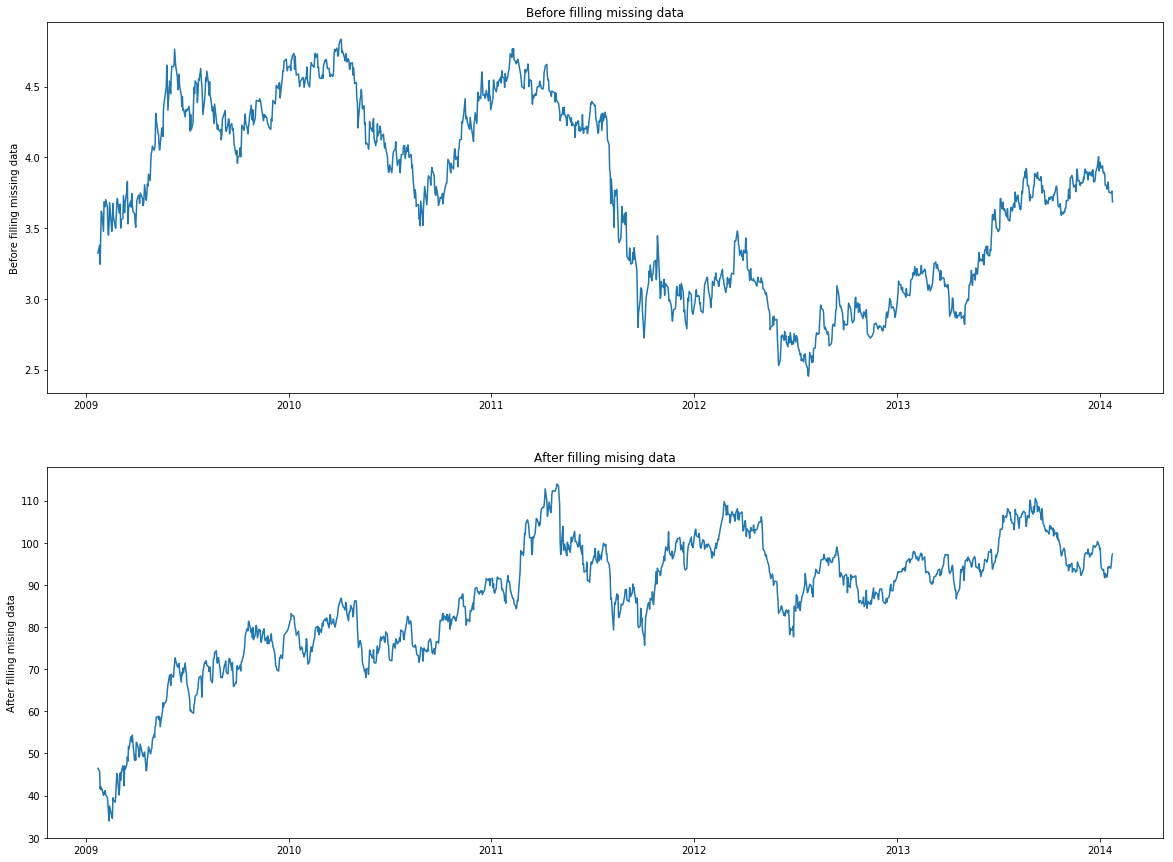

values of the factor 1 before and after filling missing values


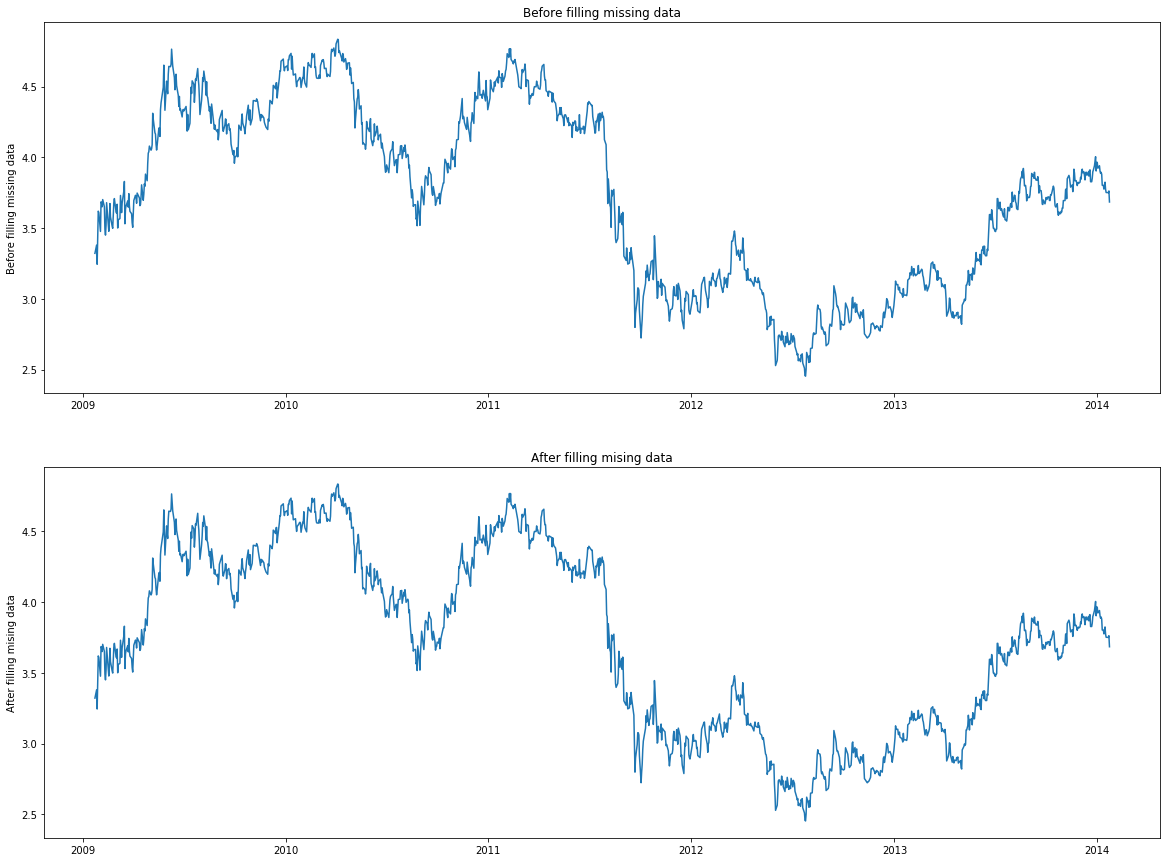

values of the factor 2 before and after filling missing values


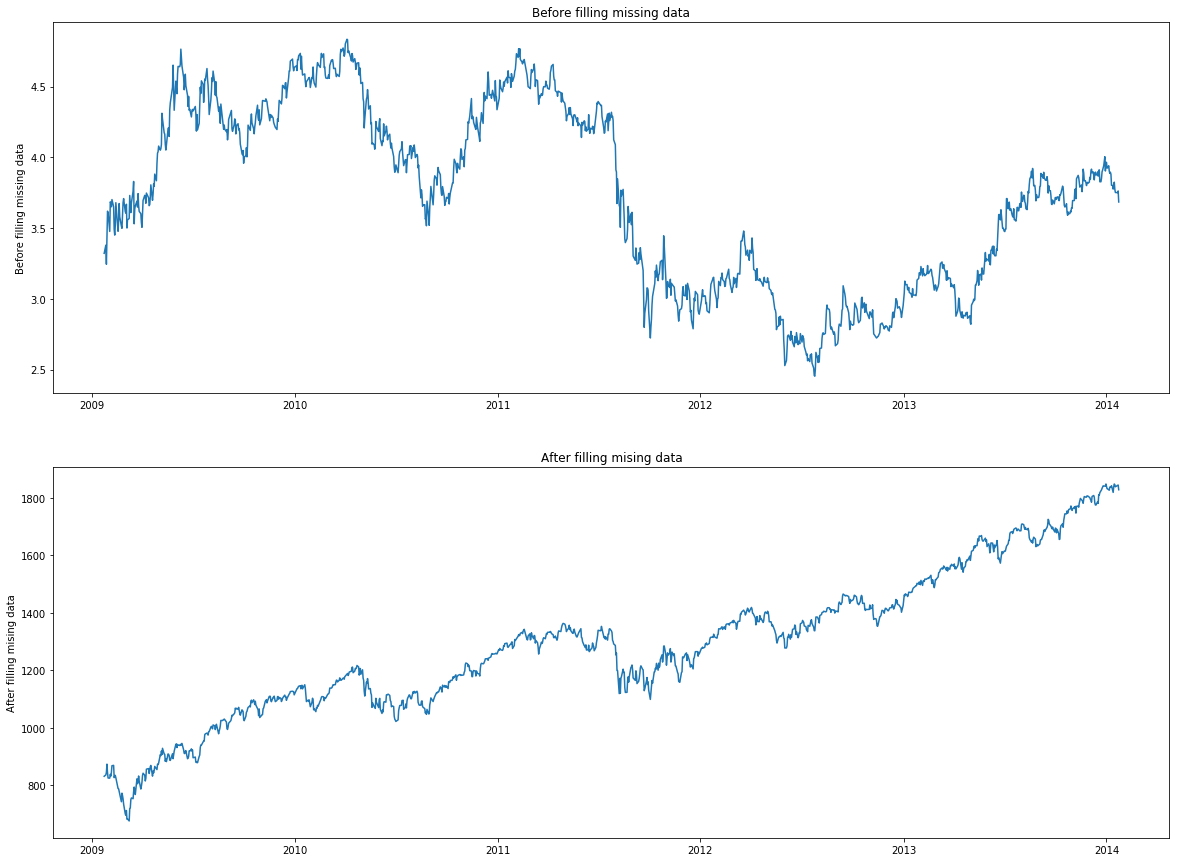

values of the factor 3 before and after filling missing values


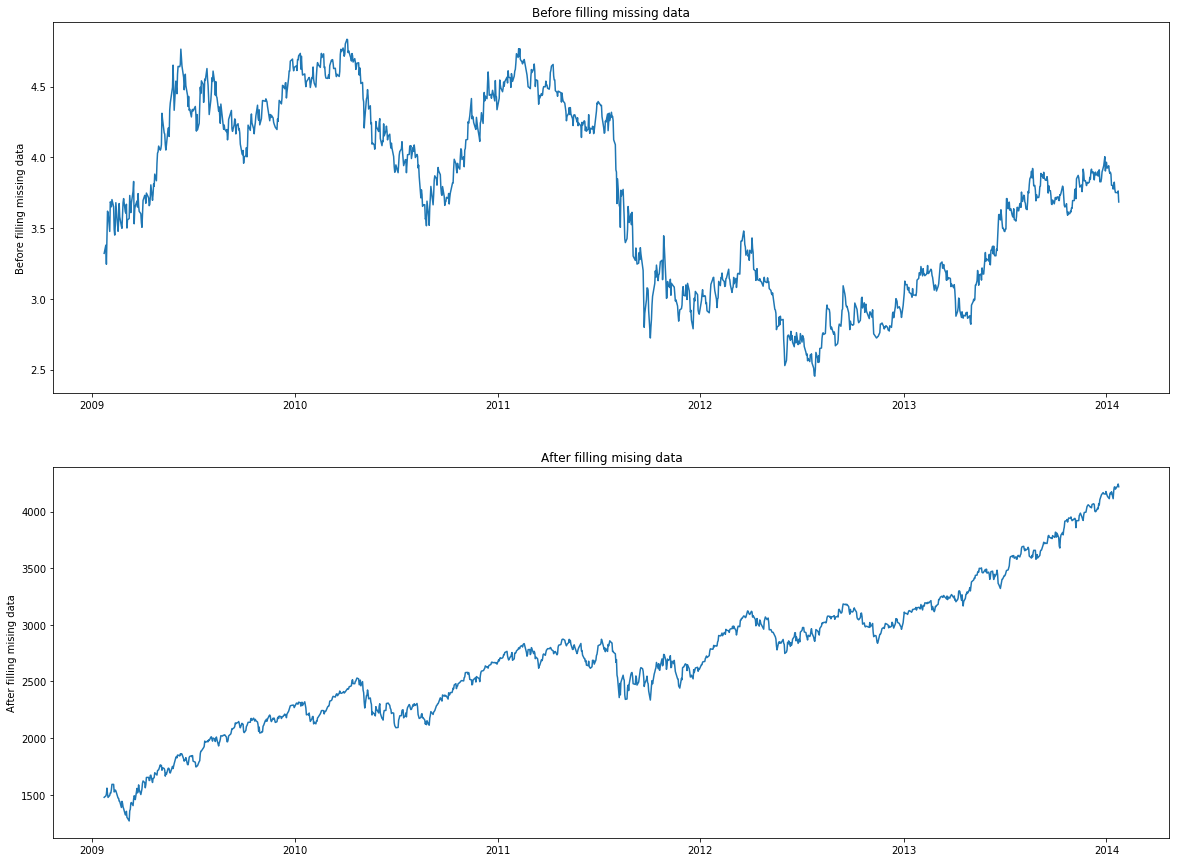

In [356]:
#Printing the values of the factors before and after filling missing values
for i in range(4):
    print("values of the factor", i, "before and after filling missing values")
    beforeAfterFilling(i)


<div class="alert alert-warning">
<div class="label label-success">COMMENT:</div><br>
The condition at the outer while loop was previously `currDate < end`; because of which the end date record (dated 23rd Jan 2014) missed getting appended into the final filled list of stocks and factors.
<br> This was corrected by changing the condition to include records with the end date 23-01-2014.
</div>

Recall that Value at Risk (VaR) deals with **losses over a particular time horizon**. We are not concerned with the absolute prices of instruments, but how those prices **change over** a given period of time. In our project, we will set that length to two weeks: we use the sliding window method to transform time series of prices into an overlapping sequence of price change over two-week intervals.

The figure below illustrates this process. The returns of market factors after each two-week interval is calculated in the very same way.

![](https://dl.dropboxusercontent.com/s/r9ucsicichb6gjh/two-week-time-interval.svg)

In [296]:
def buildWindow(seq, k=2):
    "Returns a sliding window (of width k) over data from iterable data structures"
    "   s -> (s0,s1,...s[k-1]), (s1,s2,...,sk), ...                   "
    it = iter(seq)
    result = tuple(islice(it, k))
    if len(result) == k:
        yield result  
    for elem in it:
        result = result[1:] + (elem,)
        yield result

#### Question 4.6
<div class="alert alert-info">
Compute the returns of the stocks after each two-week time window.
</div>

In [297]:
def calculateReturn(window):
    # return the change of value after two weeks
    return window[1] - window[0]

def twoWeekReturns(history):
    # we use 10 instead of 14 to define the window
    # because financial data does not include weekends
    return [calculateReturn( \
                            [entry[0][1],entry[-1][1]]
                           ) 
            for entry in buildWindow(history, 11)] # We changed the width parameter from 10 to 11. The reason is explained below.

stocksReturns = list(map(twoWeekReturns, stocks))
factorsReturns = list(map(twoWeekReturns, factors))

# test our functions
print("The first 5 returns of stock 0:\n", np.array(stocksReturns[0][:5]))
print("\nThe last 5 returns of stock 0:\n", np.array(stocksReturns[0][-5:]))

The first 5 returns of stock 0:
 [ 1.130001  0.58     -0.780001 -1.660002 -0.100001]

The last 5 returns of stock 0:
 [-1.329998 -0.689999 -0.36      0.139999 -1.029999]


**Testing `buildWindow`**

In [298]:
#test to show that we need to change 10 by 11 in the builWindow parameter, in order to calculate the return from 
#monday to monday

l=[1+i%5 for i in range(15)]
print([i for i in buildWindow(l,10)])
print("\n",[i for i in buildWindow(l,11)])

[(1, 2, 3, 4, 5, 1, 2, 3, 4, 5), (2, 3, 4, 5, 1, 2, 3, 4, 5, 1), (3, 4, 5, 1, 2, 3, 4, 5, 1, 2), (4, 5, 1, 2, 3, 4, 5, 1, 2, 3), (5, 1, 2, 3, 4, 5, 1, 2, 3, 4), (1, 2, 3, 4, 5, 1, 2, 3, 4, 5)]

 [(1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1), (2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2), (3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3), (4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4), (5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5)]


<div class= 'alert alert-warning'>
We test the `buildWindow` function with two possible width parameters k=10 and k=11.
The result is a list of tuples representing the index of weekday. 
<br>With a width, k=10: Consider the first tuple containing information from Monday of the current week to Friday of the week after. This does not account for the following week's Monday to compute the corresponding return correctly. 
<br>So, when the difference is computed, the time window is not exactly 2 weeks (it is one day less than 2 weeks; for example: Monday's value - Friday's value).
<br>
In order to overcome this, a width of 11 is used to build the time window; such that we obtain returns of exactly 2 weeks. 

</div>

Alright! Now we have data that is properly aligned to start the training process: stocks' returns and factors' returns, per time windows of two weeks. Next, we will apply the MCS method.

## 5.5. Summary guidelines to apply the MCS method on the data we prepared
Next, we overview the steps that you have to follow to build a model of your data, and then use Monte Carlo simulations to produce output distributions:

- **Step 1**: Defining the relationship between the market factors and the instrument's returns. This relationship takes the form of a model fitted to historical data.
- **Step 2**: Defining the distributions for the market conditions (particularly, the returns of factors) that are straightforward to sample from. These distributions are fitted to historical data. 
- **Step 3**: Generate the data for each trial of a Monte Carlo run: this amount to generating the random values for market conditions along with these distributions.
- **Step 4**: For each trial, from the above values of market conditions, and using the relationship built in step 1, we calculate the return for each instrument and the total return. We use the returns to define an empirical distribution over losses. This means that, if we run 100 trials and want to estimate the 5% VaR, we would choose it as the loss from the trial with the fifth greatest loss.
- **Step 5**: Evaluating the result

## 5.6. Applying MCS

### Step 1: Defining relationship between market factors and instrument's returns

In our simulation, we will use a simple linear model. By our definition of return, a factor return is a **change** in the value of a market factor **over a particular time period**, e.g. if the value of the S&P 500 moves from 2000 to 2100 over a time interval, its return would be 100.

A vector that contains the return of 4 market factors is called a *market factor vector*. Generally, instead of using this vector as features, we derive a set of features from simple transformation of it. In particular, a vector of 4 values is transformed into a vector of length $m$ by function $F$. In the simplest case $F(v) = v$.

Denote $v_t$ the market factor vector, and $f_t$ the transformed features of $v_t$ at time $t$.

$f_{tj}$ is the value of feature $j$ in $f_t$.

Denote $r_{it}$ the return of instrument $i$ at time $t$ and $c_i$ the [intercept term](http://blog.minitab.com/blog/adventures-in-statistics/regression-analysis-how-to-interpret-the-constant-y-intercept) of instrument $i$.

We will use a simple linear function to calculate $r_{it}$ from $f_t$:

$$
r_{it} = c_i + \sum_{j=1}^{m}{w_{ij}*f_{tj}}
$$

where $w_{ij}$ is the weight of feature $j$ for instrument $i$.

All that above means that given a market factor vector, we have to apply featurization and then use the result as a surrogate for calculating the return of the instruments, using the above linear function.

There are two questions that we should consider: **how we apply featurization to a factor vector?** and **how to pick values for $w_{ij}$?**

**How we apply featurization to a factor vector?**
In fact, the instruments' returns may be non-linear functions of the factor returns. So, we should not use factor returns as features in the above linear function. Instead, we transform them into a set of features with different size. In this Notebook, we can include some additional features in our model that we derive from non-linear transformations of the factor returns. We will try adding two more features for each factor return: its square and its square root values. So, we can still assume that our model is a linear model in the sense that the response variable is a linear function of the new features. *Note that the particular feature transformation described here is meant to be an illustrative example of some of the options that are available: it shouldn't be considered as the state of the art in predictive financial modeling!!*.

**How to pick values for $w_{ij}$?**

For all the market factor vectors in our historical data, we transform them to feature vectors. Now, we have feature vectors in many two-week intervals and the corresponding instrument's returns in these intervals. We can use Ordinary Least Square (OLS) regression model to estimate the weights for each instrument such that our linear function can fit to the data. The parameters for OLS function are:

- `x`: The collection of columns where **each column** is the value of **a feature** in many two-week interval
- `y`: The return of an instrument in the corresponding time interval of x.

The figure below shows the basic idea of the process to build a statistical model for predicting the returns of stock X.

![](https://dl.dropboxusercontent.com/s/kbjtwmnr4w31uev/process-build-model3.svg)


### Question 5
#### Question 5.1

<div class="alert alert-info">
Currently, our data is in form of:  

$$
factorsReturns=
\begin{bmatrix}
 r_{00} & r_{01} & r_{02} & ... & r_{0k} \\
 r_{10} & r_{11} & r_{12} & ... & r_{1k} \\
 ... & ... & ... & ... & ... \\
 r_{n0} & r_{n1} & r_{n2} & ... & r_{nk}\\
\end{bmatrix}
$$

<ul></ul>

$$
stocksReturns=
\begin{bmatrix}
 s_{00} & s_{01} & s_{02} & ... & s_{0k} \\
 s_{10} & s_{11} & s_{12} & ... & s_{1k} \\
 ... & ... & ... & ... & ... \\
 s_{n0} & s_{n1} & s_{n2} & ... & s_{nk}\\
\end{bmatrix}
$$

<ul></ul>

Where, $r_{ij}$ is the return of factor $i^{th}$ in time window $j^{th}$, $k$ is the number of time windows, and $n$ is the number of factors. A similar definition goes for $s_{ij}$.

<ul></ul>

In order to use OLS, the parameter must be in form of:

<ul></ul>

$$
x=factorsReturns^T =
\begin{bmatrix}
 r_{00} & r_{10} & ... & r_{n0} \\
 r_{01} & r_{11} & ... & r_{n1} \\
 r_{02} & r_{12} & ... & r_{n2}\\
 ... & ... & ... & ... \\
 r_{0k} & r_{1k} & ... & r_{nk}\\
\end{bmatrix}
$$

<ul></ul>

Whereas, $y$ can be any row in `stocksReturns`.

<ul></ul>

So, we need a function to transpose a matrix. Write a function named `transpose` to do just that.
</div>

In [299]:
def transpose(matrix):
    return np.array(matrix).transpose().tolist()
    
# test function
assert (transpose([[1,2,3], [4,5,6], [7,8,9]]) == [[1, 4, 7], [2, 5, 8], [3, 6, 9]]), "Function transpose runs incorrectly"


#### Question 5.2
<div class="alert alert-info">
Write a function named `featurize` that takes a list factor's returns $[x_1, x_2,...,x_k]$ and transform it into a new list of features $[u_1,u_2,..,u_k, v_1, v_2,..,v_k, x_1,x_2,...,x_k]$.

<ul></ul>

Where,  


$u_i$ = $\left\{
	\begin{array}{ll}
		x_i^2 & \mbox{if } x_i \geq 0 \\
		-x_i^2 & \mbox{if } x_i < 0
	\end{array}
\right.
$

<ul></ul>

and  

$v_i$ = $\left\{
	\begin{array}{ll}
		\sqrt{x_i} & \mbox{if } x_i \geq 0 \\
		-\sqrt{x_i} & \mbox{if } x_i < 0
	\end{array}
\right.
$  

</div>

In [300]:

def featurize(factorReturns):
    squaredReturns = [np.sign(factorReturns[i])*factorReturns[i]**2 for i in range(len(factorReturns)) ]
    squareRootedReturns =  [np.sign(factorReturns[i])*math.sqrt(abs(factorReturns[i])) for i in range(len(factorReturns)) ]
    # concat new features
    return squaredReturns+squareRootedReturns+factorReturns

# test our function
assert (featurize([4, -9, 25]) == [16, -81, 625, 2, -3, 5, 4, -9, 25]), "Function runs incorrectly"

#### Question 5.3
<div class="alert alert-info">
Using OLS, estimate the weights for each feature on each stock. What is the shape of `weights` (size of each dimension)?  

Explain it.
</div>

In [357]:
def estimateParams(y, x):
    return sm.OLS(y, x).fit().params

# transpose factorsReturns
factorMat = transpose(factorsReturns)

# featurize each row of factorMat
factorFeatures = list(map(lambda row: featurize(row),factorMat))

# OLS require parameter is a numpy array
factor_columns = np.array(factorFeatures)

#add a constant - the intercept term for each instrument i.
factor_columns = sm.add_constant(factor_columns, prepend=True)

# estimate weights
weights = [estimateParams(stockReturns,factor_columns) for stockReturns in stocksReturns]

#print("\n weights for stock0:", weights[0])
weigths_pd = pd.DataFrame(weights, columns=['intercept','squaref1','squaref2','squaref3','squaref4',
                                  'rootf1','rootf2','rootf3','rootf4',
                                  '1-Oil','2-Treasury','3-GSPC','4-IXIC'])
display(weigths_pd)


,intercept,squaref1,squaref2,squaref3,squaref4,rootf1,rootf2,rootf3,rootf4,1-Oil,2-Treasury,3-GSPC,4-IXIC
0,0.012012,-0.000309,-8.830637,0.000216,-4.348141e-05,0.117076,-1.288749,0.019996,-0.058931,-0.047747,5.141444,0.002126,0.011030
1,-0.117359,0.000445,-4.391931,0.000217,-3.816601e-05,0.139005,-0.052447,0.082970,-0.017286,-0.063116,2.741747,-0.029755,0.026511
2,-0.017771,0.002940,-1.978962,0.000064,-1.903047e-05,0.055325,-0.241846,0.002413,-0.012579,-0.061239,1.086345,-0.001798,0.004304
3,0.056310,-0.000174,3.291273,-0.000032,-1.307169e-06,0.028170,1.756874,-0.025142,-0.017397,-0.006165,-4.976734,0.004833,0.006053
4,-0.211745,0.008660,4.390067,0.000217,-2.942908e-05,0.047523,0.850478,0.154246,0.022220,-0.118914,-0.770379,-0.036099,0.010899
5,0.025354,-0.000548,2.690970,0.000014,-3.216571e-06,-0.034286,0.202700,0.030538,0.003622,0.016057,-1.411854,-0.003360,-0.000359
6,0.050783,0.002079,1.095591,-0.000189,2.863952e-05,0.194118,-0.372314,-0.030835,0.024705,-0.098539,-0.421046,0.021131,-0.002449
7,-0.010675,0.004685,1.260587,0.000015,-2.165906e-05,0.068951,-0.390883,0.025144,-0.002683,-0.068916,0.573906,-0.002388,0.004984
8,-0.053181,0.002868,3.140852,0.000128,-2.812925e-05,0.047188,0.198269,0.010964,-0.014671,-0.039741,-1.258182,-0.007897,0.006628
9,-0.031090,0.010978,15.625653,0.000292,-3.592266e-05,0.540222,3.030767,-0.080409,0.091398,-0.311929,-12.987659,0.026654,-0.000386


In [330]:
print("weights' shape:\t\t",np.array(weights).shape)
print("\nstocksReturns' shape:\t", np.array(stocksReturns).shape)
print("factor_columns' shape:\t",factor_columns.shape)
print("factorsReturns: \t", np.shape(np.array(factorsReturns)))
print("factorMat: \t\t", np.shape(factorMat))

weights' shape:		 (120, 13)

stocksReturns' shape:	 (120, 1295)
factor_columns' shape:	 (1295, 13)
factorsReturns: 	 (4, 1295)
factorMat: 		 (1295, 4)


<div class="alert alert-warning">
<div class="label label-success">COMMENT:</div><br>
`weights` has a shape of (29, 13) where 29 is the number of stocks that have more than 5 years  data out of the 35. </br>
13 is the number of features after featurize the 4 features to obtain 4 squares and 4 square roots and 1 extra column which corresponds to the intercept term for each instrument. </br>`stocksReturns` has a shape of  (29, 1295) where 1295 is the number of time windows and 4 is the number of factors. 
</br>`factor_colums` have been transposed.

</div>

### Step 2: Defining the distributions for the market conditions
Since we cannot define the distributions for the market factors directly, we can only approximate their distribution.
The best way to do that, is plotting their value. However, these values may fluctuate quite a lot. 

Next, we show how to use the Kernel density estimation (KDE) technique to approximate such distributions. In brief, kernel density estimation is a way of smoothing out a histogram: this is achieved by assigning (or centering) a probability distribution (usually a normal distribution) to each data point, and then summing. So, a set of two-week-return samples would result in a large number of "super-imposed" normal distributions, each with a different mean. 

To estimate the probability density at a given point, KDE evaluates the PDFs of all the normal distributions at that point and takes their average. The smoothness of a kernel density plot depends on its *bandwidth*, and the standard deviation of each of the normal distributions. For a brief introduction on KDE, please refer to this [link](https://en.wikipedia.org/wiki/Kernel_density_estimation).

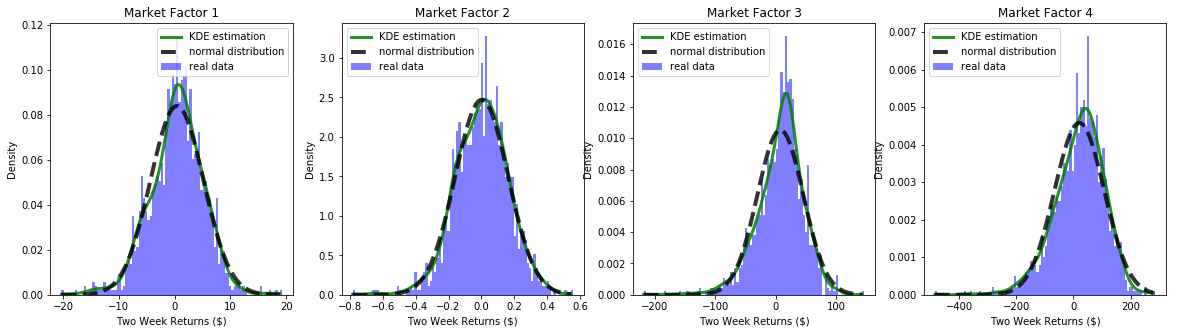

In [303]:
from statsmodels.nonparametric.kernel_density import KDEMultivariate
from statsmodels.nonparametric.kde import KDEUnivariate
import matplotlib.pyplot as plt
import scipy

def plotDistribution(samples, n, title):
    vmin = min(samples)
    vmax = max(samples)
    stddev = np.std(samples)
    mu=np.mean(samples)
    
    domain = np.arange(vmin, vmax, (vmax-vmin)/100)
    
    # a simple heuristic to select bandwidth
    bandwidth = 1.06 * stddev * pow(len(samples), -.2)
    
    # estimate density
    kde = KDEUnivariate(samples)
    kde.fit(bw=bandwidth)
    density = kde.evaluate(domain)
    
    # plot
    
    plt.subplot(n)
    plt.hist(samples, normed=1, bins=100, color='b', alpha=0.5, label='real data')
    plt.plot(domain, density, lw=3, color='g',alpha=0.85, label='KDE estimation')
    plt.plot(domain, mlab.normpdf(domain, mu, stddev), 'k--', alpha=0.8, label='normal distribution', lw=4)
    plt.title(title)
    plt.xlabel('Two Week Returns ($)')
    plt.ylabel('Density')
    plt.legend()

    if n==144:
        plt.show()
        
fig=plt.figure(figsize=(20,5))

plotDistribution(factorsReturns[0], 141, 'Market Factor 1')
plotDistribution(factorsReturns[1], 142, 'Market Factor 2')
plotDistribution(factorsReturns[2], 143, 'Market Factor 3')
plotDistribution(factorsReturns[3], 144, 'Market Factor 4')

<div class='alert alert-warning'>
**Understanding the probability of factor returns having a normal distribution using QQ Plots** 
</div>

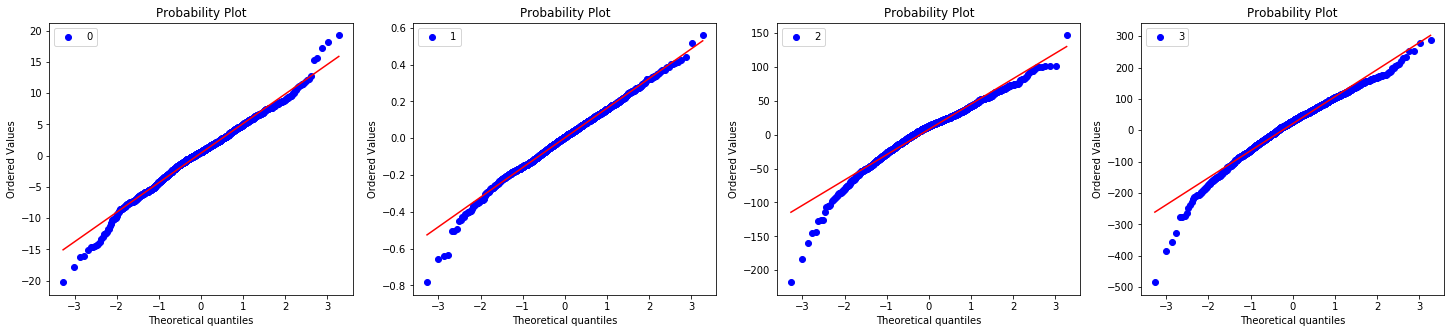

In [304]:
#a function to plot the QQ graph for samples and distribution dist; n is the subplot position and sample_nbr the factor number 
def QQplot(samples, dist, n, sample_nbr, shape_param=()):
    plt.subplot(n)
    stats.probplot(samples, dist=dist, plot=pylab, sparams=shape_param )
    pylab.legend(str(sample_nbr))
    if n==144:
        pylab.show()

#set the figure size
fig=plt.figure(figsize=(25,5))

#QQplot of factor 0's returns in position 1
QQplot(factorsReturns[0], 'norm', 141, 0)
#QQplot of factor 1's returns in position 2
QQplot(factorsReturns[1], 'norm', 142, 1)
#QQplot of factor 2's returns in position 3
QQplot(factorsReturns[2], 'norm', 143, 2)
#QQplot of factor 3's returns in position 4
QQplot(factorsReturns[3], 'norm', 144, 3)


<div class="alert alert-warning">
<div class="label label-success">COMMENT:</div><br>
A Q–Q (quantile-quantile) plot is a probability plot, which is a graphical method for comparing two probability distributions by plotting their quantiles against each other. Here we compare our factor returns (blue dots) and the normal distribution (red line). We can see that both are almost aligned. We can then approximate our factor returns by a normal distribution.<br>
 This good approximation can also be seen from the distribution plot shown in the previous cell.
</div>

For the sake of simplicity, we can say that our smoothed versions of the returns of each factor can be represented quite well by a normal distribution. Of course, more exotic distributions, perhaps with fatter tails, could fit more closely the data, but it is outside the scope of this Notebook to proceed in this way.

Now, the simplest way to sample factors returns is to use a normal distribution for each of the factors, and sample from these distributions independently. However, this approach ignores the fact that market factors are often correlated. For example, when the price of crude oil is down, the price of treasury bonds is down too. We can check our data to verify about the correlation.

### Question 6

#### Question 6.1
<div class="alert alert-info">

Calculate the correlation between market factors and explain the result.

</div>

<div class="label label-success">HINT</div> function `np.corrcoef` might be useful.


Correlation:
 [[1.         0.39316717 0.46510228 0.45118714]
 [0.39316717 1.         0.55188265 0.55093046]
 [0.46510228 0.55188265 1.         0.9514752 ]
 [0.45118714 0.55093046 0.9514752  1.        ]]


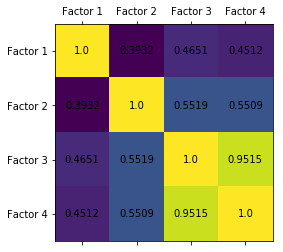

In [305]:
#Since we are trying to see the correlation between the factors returs, shouldn't we compute the corrcoef
#between factorsReturns[0] and factorsReturns[1] and so on?
correlation = np.corrcoef(np.array(factorsReturns))
print('\nCorrelation:\n', correlation)

#Visulazing the correlation matrix
#Labels for the graph axis
factors_corr_labels = ['Factor 1', 'Factor 2', 'Factor 3', 'Factor 4']
fig = plt.figure(figsize = (8,6))
fig, ax = plt.subplots()
ax.matshow(correlation)
x_pos = np.arange(len(factors_corr_labels))
plt.xticks(x_pos, factors_corr_labels)

y_pos = np.arange(len(factors_corr_labels))
plt.yticks(y_pos, factors_corr_labels)

#Displaying the values in each cell of the matrix display graph
for (i, j), z in np.ndenumerate(correlation):
    ax.text(j, i, np.round(correlation[i][j],4), ha='center', va='center')

plt.show()


<div class="alert alert-warning">
<div class="label label-success">INTERPRETATION:</div><br>
Correlation measures the degree of associativity between two variables. 
Correlation coeffictients are a measure of the direction and strength of the linear relationship.<br>
A positive correlation between two variables indicates that an increase in one variable shows a corresponding increase in the other variable. Negative correlation is when variables behave such that an increase in one shows a corresponding decrease in the other.<br>
The correlation matrix above is a matrix whose elements are correlation coefficients of market factors (specifically, correlation between factor returns and the time window).
The diagonal elements are 1 since the correlation between same (equal) variables is the highest (=1).
The rest of the coefficients are positive indicating that market factors are related such that increase in one factor shows a corresponding increase in the other.
<br><br>
The matrix is symetric because the correlation between $Factor_i$ and $Factor_j$ is the same as the correlation between $Factor_j$ and $Factor_i$.

Here is the general layout of the matrix for 4 variables:
</div>


| || factor1 | factor2 | factor3 | factor4 |
| ----|----|----|----|----|
|<b>factor1</b> || 1 | $c_1$$_2$ | $c_1$$_3$ | $c_1$$_4$ |
|<b>factor2</b> || $c_1$$_2$ | 1  | $c_2$$_3$ | $c_2$$_4$ |
|<b>factor3</b> || $c_1$$_3$ | $c_2$$_3$  | 1 | $c_3$$_4$ |
|<b>factor4</b> || $c_1$$_4$ | $c_2$$_4$  | $c_3$$_4$ | 1 |


<div class="alert alert-warning">
 All 4 factors are somehow correlated, their correlation coefficient are positive. That means if one factor get larger, other factors also follow that trend.
</div>


The multivariate normal distribution can help here by taking the correlation information between the factors into account. Each sample from a multivariate normal distribution can be thought of as a vector. Given values for all of the dimensions but one, the distribution of values along that dimension is normal. But, in their joint distribution, the variables are not independent.

For this use case, we can write:

$$
\left(\begin{array}{c}f_{1}\\f_{2}\\f_{3}\\f_{4} \end{array}\right)
\sim N 
\left[
  \left(
    \begin{array}{c}
      \mu_1\\ \mu_2 \\ \mu_3 \\ \mu_4 
    \end{array}
  \right), 
  \left(
    \begin{array}{cccc}
      \sigma^2_1 & \rho_{12} \sigma_1\sigma_2 & \rho_{13} \sigma_1\sigma_3 & \rho_{14} \sigma_1\sigma_4 \\ 
      \rho_{12}\sigma_2\sigma_1 & \sigma^2_2 & \rho_{23} \sigma_2\sigma_3 & \rho_{24} \sigma_2\sigma_4\\
      \rho_{13} \sigma_3\sigma_1 & \rho_{23} \sigma_3\sigma_2 & \sigma^2_3 & \rho_{34} \sigma_3\sigma_4 \\ 
      \rho_{14} \sigma_4\sigma_1 & \rho_{24} \sigma_4\sigma_2 & \rho_{34} \sigma_3\sigma_4 & \sigma_4^2 \\ 
    \end{array}
  \right)
\right]
$$

Or,

$$
f_t \sim N(\mu, \sum)
$$

Where $f_1$, $f_2$, $f_3$ and $f_4$ are the market factors, $\sigma_i$ is the standard deviation of factor $i$, $\mu$ is a vector of the empirical means of the returns of the factors and $\sum$ is the empirical covariance matrix of the returns of the factors.

The multivariate normal is parameterized with a mean along each dimension and a matrix describing the covariance between each pair of dimensions. When the covariance matrix is diagonal, the multivariate normal reduces to sampling along each dimension independently, but placing non-zero values in the off-diagonals helps capture the relationships between variables. Whenever having the mean of this multivariate normal distribution and its covariance matrix, we can generate the sample values for market factors.

Next, we will calculate the mean and the covariance matrix of this multivariate normal distribution from the historical data.


#### Question 6.2
<div class="alert alert-info">

Calculate the covariance matrix $\sum$ and the means $\mu$ of factors' returns then generate a random vector of factors return that follows a multivariate normal distribution $\sim N(\mu, \sum)$

</div>

<div class="label label-success">HINT</div>
Function `np.cov` can help calculating covariance matrix. Function `np.random.multivariate_normal(<mean>, <cov>)` is often used for generating samples.

In [358]:
factorCov = np.cov(np.array(factorsReturns))
factorMeans = [sum(factorsReturns_window)/len(factorsReturns_window) for factorsReturns_window in factorsReturns]

# Finding min, max and mode for triangular dist 
factorMin = [min(factorsReturns_window) for factorsReturns_window in factorsReturns]
factorMax = [max(factorsReturns_window) for factorsReturns_window in factorsReturns]
factorVar = [np.var(factorsReturns_window) for factorsReturns_window in factorsReturns]
sample = np.random.multivariate_normal(factorMeans, factorCov)


print('Factors covariance matrix: \n', factorCov)
print('\nFactors means', factorMeans)
print('Samples generated using the mean and covariance:', sample)

[22.512029915236802, 0.02607254208255691, 1435.1341498639586, 7568.360727199167]
Factors covariance matrix: 
 [[2.25294272e+01 3.01447546e-01 8.36637914e+01 1.86380490e+02]
 [3.01447546e-01 2.60926909e-02 3.37847083e+00 7.74506166e+00]
 [8.36637914e+01 3.37847083e+00 1.43624322e+03 3.13819645e+03]
 [1.86380490e+02 7.74506166e+00 3.13819645e+03 7.57420954e+03]]

Factors means [0.4024478764478773, 0.001998455598455606, 7.712640781467181, 20.77304187953668]
Samples generated using the mean and covariance: [-0.03172434 -0.02229812 -8.33778532 -1.75571952]


### Step 3&4: Generating samples, running simulation and calculating the VaR

We define some functions that helps us calculating VaR 5%. You will see that the functions below are pretty complicated! This is why we provide a solution for you: however, study them well!!

The basic idea of calculating VaR 5% is that we need to find a value such that only 5% of the losses are bigger than it. That means the 5th percentile of the losses should be VaR 5%.

VaR can sometimes be problematic though, since it does give any information on the extent of the losses which can exceed the VaR estimate. CVar is an extension of VaR that is introduced to deal with this problem. Indeed, CVaR measures the expected value of the loss in those cases where VaR estimate has been exceeded.

In [307]:
def fivePercentVaR(trials):
    numTrials = trials.count()
    topLosses = trials.takeOrdered(max(round(numTrials/20.0), 1))
    return topLosses[-1]

# an extension of VaR
def fivePercentCVaR(trials):
    numTrials = trials.count()
    topLosses = trials.takeOrdered(max(round(numTrials/20.0), 1))
    return sum(topLosses)/len(topLosses)

def bootstrappedConfidenceInterval(
      trials, computeStatisticFunction,
      numResamples, pValue):
    stats = []
    for i in range(0, numResamples):
        resample = trials.sample(True, 1.0)
        stats.append(computeStatisticFunction(resample))
    stats.sort()
    lowerIndex = int(numResamples * pValue / 2 - 1)
    upperIndex = int(np.ceil(numResamples * (1 - pValue / 2)))
    return (stats[lowerIndex], stats[upperIndex])

Next, we will run the Monte Carlo simulation 10,000 times, in parallel using Spark. Since your cluster has 12 cores (two Spark worker nodes, each with 6 cores), we can set `parallelism = 12` to dispatch simulation on these cores, across the two machines (remember, those are not really "physical machines", they are Docker containers running in our infrastructure).

### Question 7
<div class="alert alert-info">
Complete the code below to define the simulation process and calculate VaR 5%.
</div>

In [308]:
# RUN SILMULATION
def simulateTrialReturns(numTrials, factorMeans, factorCov, weights):
    trialReturns = []
    for i in range(0, numTrials):
        # generate sample of factors' returns
        trialFactorReturns = np.random.multivariate_normal(factorMeans, factorCov)
        
        # featurize the factors' returns
        trialFeatures = featurize(transpose(trialFactorReturns))
        
        # insert weight for intercept term
        trialFeatures.insert(0,1)
        
        trialTotalReturn = 0
        
        # calculate the return of each instrument
        # then calulate the total of return for this trial features
        trialTotalReturn = np.sum(np.dot(np.array(weights), np.array(trialFeatures)))
        
        trialReturns.append(trialTotalReturn)
    return trialReturns


        
parallelism = 4
numTrials = 10000
trial_indexes = list(range(0, parallelism))
seedRDD = sc.parallelize(trial_indexes, parallelism)
bFactorWeights = sc.broadcast(weights)

time0 = time()
trials = seedRDD.flatMap(lambda idx: \
                simulateTrialReturns(
                    max(int(numTrials/parallelism), 1), 
                    factorMeans, factorCov,
                    bFactorWeights.value
                ))
trials.cache()

valueAtRisk = fivePercentVaR(trials)
conditionalValueAtRisk = fivePercentCVaR(trials)
time1 = time()
print("Value at Risk(VaR) 5%:", valueAtRisk)
print("Conditional Value at Risk(CVaR) 5%:", conditionalValueAtRisk)
print("Time taken = ", time1 - time0)

Value at Risk(VaR) 5%: -21.387284031618062
Conditional Value at Risk(CVaR) 5%: -27.731465771625903
Time taken =  0.7219159603118896


<div class="alert alert-warning">
<b>COMMENT:</b><br>
One important parameter for parallel collections is the number of partitions to cut the dataset into. Spark will run one task for each partition of the cluster. Typically it is recommended to set 2-4 partitions for each CPU in the cluster.<br>
Since our cluster has rather 4 cores: four Spark worker nodes, each with 1 core. Thus, we decided to set parallelism = 4 to dispatch simulation on these cores, across the four machines. We chose this value after comparing processing times for different values multiple of 4(4, 8 and 12) and it turned out that 4 was the fastest. <br>

**INFERENCE:**<br>
The Value at risk is negative which means that with a 95% confidence level, we expect to lose nothing and instead gain the computed amount in a time period of two weeks.
</div>

The value of VaR depends on how many invested stocks and the chosen distribution of random variables. Assume that we get VaR 5% = -2.66,  that means that there is a 0.05 probability that the portfolio will fall in value by more than \$2.66 over a two weeks' period if there is no trading. In other words, the loses are less than \$2.66 over two weeks' period with 95% confidence level. When a loss over two weeks is more than \$2.66, we call it **failure** (or **exception**). Informally, because of 5% probability, we expect that there are only $0.05*W$ failures out of total $W$ windows.

### Step 5: Evaluating the results using backtesting method
In general, the error in a Monte Carlo simulation should be proportional to 1/sqrt(n), where n is the number of trials. This means, for example, that quadrupling the number of trials should approximately cut the error in half. A good way to check the quality of a result is backtesting on historical data. Backtesting is a statistical procedure where actual losses are compared to the estimated VaR. For instance, if the confidence level used to calculate VaR is 95% (or VaR 5%), we expect only 5 failures over 100 two-week time windows.

The most common test of a VaR model is counting the number of VaR failures, i.e., in how many windows, the losses exceed VaR estimate. If the number of exceptions is less than selected confidence level would indicate, the VaR model overestimates the risk. On the contrary, if there are too many exceptions, the risk is underestimated. However, it's very hard to observe the amount of failures suggested by the confidence level exactly. Therefore, people try to study whether the number of failures is reasonable or not, or will the model be accepted or rejected.

One common test is Kupiec's proportion-of-failures (POF) test. This test considers how the portfolio performed at many historical time intervals and counts the number of times that the losses exceeded the VaR. The null hypothesis is that the VaR is reasonable, and a sufficiently extreme test statistic means that the VaR estimate does not accurately describe the data. The test statistic is computed as:

$$
-2ln\Bigg(\frac{(1-p)^{T-x}p^x}{(1-\frac{x}{T})^{T-x}(\frac{x}{T})^x}\Bigg)
$$

where:

$p$ is the quantile-of-loss of the VaR calculation (e.g., in VaR 5%, p=0.05),

$x$ (the number of failures) is the number of historical intervals over which the losses exceeded the VaR 

$T$ is  the total number of historical intervals considered

Or we can expand out the log for better numerical stability:

$$
\begin{equation}
-2\Big((T-x)ln(1-p)+x*ln(p)-(T-x)ln(1-\frac{x}{T})-x*ln(\frac{x}{T})\Big)
\end{equation}
$$

If we assume the null hypothesis that the VaR is reasonable, then this test statistic is drawn from a chi-squared distribution with a single degree of freedom. By using Chi-squared distribution, we can find the `p-value` accompanying our test statistic value.  If test statistic exceeds the critical value of the Chi-squared distribution or `p-value` smaller than a significance level (e.g, 0.05), we do have sufficient evidence to reject the null hypothesis that the model is reasonable. Or we can say, in that case, the model is considered as inaccurate.

For example, assume that we calculate VaR 5% (the confidence level of the VaR model is 95%) and get value VaR = 2.26. We also observed 40 exceptions over 500 time windows. Using the formula above, the test statistic is calculated and equal to `8.08`. Compared to `3.84`, the critical value of Chi-squared distribution with one degree of freedom at probability 5%, the test statistic is larger. So, the model is rejected. The critical values of Chi-squared can be found by following [this link](https://people.richland.edu/james/lecture/m170/tbl-chi.html).<br>
However, in this Notebook, it's not a good idea to find the corresponding critical value by looking in a "messy" table, especially when we need to change the confidence level. Instead, from `p-value`, we will calculate the probability of the test statistic in Chi-square thanks to some functions in package `scipy`. If the calculated probability is smaller than the quantile of loss (e.g, 0.05), the model is rejected and vice versa.


### Question 8

#### Question 8.1
<div class="alert alert-info">

Write a function to calculate the number of failures, that is when the losses (in the original data) exceed the VaR.

</div>

<div class="label label-success">HINT</div>
<ul>
  <li>First, we need to calculate the total loss in each 2-week time interval</li>
  <li>If the total loss of a time interval exceeds VaR, then we say that our VaR fails to estimate the risk in that time interval</li>
  <li>Return the number of failures</li>
</ul>  

<div class="label label-danger">NOTE</div> The loss is often having negative value, so, be careful when compare it to VaR.

In [309]:
def countFailures(stocksReturns, valueAtRisk):
    failures = 0
    # iterate over time intervals
    for i in range(0, len(stocksReturns[0])):
        # calculate the losses in each time interval
        loss = np.sum(np.array(stocksReturns)[:,i])
        
        # if the loss exceeds VaR
        if loss < valueAtRisk :
            failures += 1
    return failures


#### Question 8.2
<div class="alert alert-info">

Write a function named `kupiecTestStatistic` to calculate the test statistic which was described in the above equation.

</div>

In [310]:
def kupiecTestStatistic(total, failures, confidenceLevel):
    failureRatio = failures/total
    logNumer = math.log((1 - confidenceLevel)**(total-failures) * confidenceLevel**failures)
    logDenom = math.log((1 - failureRatio)**(total-failures) * failureRatio**failures)
    return -2 * (logNumer - logDenom)
    
# test the function
assert (round(kupiecTestStatistic(250, 36, 0.1), 2) == 4.80), "function kupiecTestStatistic runs incorrectly"

Now we can find the p-value accompanying our test statistic value.

In [311]:
def kupiecTestPValue(stocksReturns, valueAtRisk, confidenceLevel):
    failures = countFailures(stocksReturns, valueAtRisk)
    if failures==0:
        failures=1
        
    print("Number of failures:", failures)
    total = len(stocksReturns[0])
    testStatistic = kupiecTestStatistic(total, failures, confidenceLevel)
    #return 1 - stats.chi2.cdf(testStatistic, 1.0)
    return stats.chi2.sf(testStatistic, 1.0)

varConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentVaR, 100, 0.05)
cvarConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentCVaR, 100, .05)
print("VaR confidence interval: " , varConfidenceInterval)
print("CVaR confidence interval: " , cvarConfidenceInterval)
print("Kupiec test p-value: " , kupiecTestPValue(stocksReturns, valueAtRisk, 0.05))


VaR confidence interval:  (-22.053528034820765, -20.77910960814701)
CVaR confidence interval:  (-28.552138502993227, -26.910509363910098)
Number of failures: 101
Kupiec test p-value:  1.8044361602279846e-05


<div class='alert alert-warning'>
<h3>Computing the p-value for all price indicators OHLC</h3>
The p-values computed above can be observed to identify that using 'Low' as a price indicator will result in a high p-value of 0.24507184 which indicates that our null hypothesis is dependable.
<br>However, choosing 'Low' will underestimate the loss which also leads to underestimation of the VaR. This may cause possible unexpected losses.
We could have used either the 'Close' or the average OHLC as an indicator for price. 
<br>Since we can see that the p-values for these variants are almost equal, we chose to use 'Close'.
</div>

<div class='alert alert-warning'>

**Using Adj Close** 
<br>VaR confidence interval:  (-27.206967381992328, -27.76921110591741)
<br>CVaR confidence interval:  (-34.7989921020734, -35.07543152965588)
<br>num failures: 5
<br>Kupiec test p-value:  0.016421166928627367
<br><br>
**Using Open**
<br>VaR confidence interval:  (-19.67688520669519, -20.035342941586425)
<br>CVaR confidence interval:  (-25.783578329655384, -25.25099906150367)
<br>num failures: 4
<br>Kupiec test p-value:  0.07092374971053614
<br><br>
**Using High**
<br>VaR confidence interval:  (-19.058776348394826, -18.866761954972162)
<br>CVaR confidence interval:  (-23.663987430825266, -23.802606505198654)
<br>num failures: 4
<br>Kupiec test p-value:  0.07092374971053614
<br><br>
**Using Low**
<br>VaR confidence interval:  (-20.230524990275708, -19.781008138423992)
<br>CVaR confidence interval:  (-25.432286854603774, -25.754880314202445)
<br>num failures: 3
<br>Kupiec test p-value:  0.2450718428210974
<br><br>
**Using Close**
<br>VaR confidence interval:  (-20.612834719439718, -20.17749513639731)
<br>CVaR confidence interval:  (-25.694547084629843, -26.077755419089645)
<br>num failures: 4
<br>Kupiec test p-value:  0.07092374971053614
<br><br>
**Using Average OHLC**
<br>VaR confidence interval:  (-19.510241806258975, -19.403775194154747)
<br>CVaR confidence interval:  (-24.962379260701013, -24.767077376016633)
<br>num failures: 4
<br>Kupiec test p-value:  0.07092374971053614
<br><br>
**Using Average HLC**
<br>VaR confidence interval:  (-14.55084648176191, -14.431620862178278)
<br>CVaR confidence interval:  (-18.72442480181103, -18.41532608496523)
<br>num failures: 4
<br>Kupiec test p-value:  0.07092374971053614
</div>


#### Question 8.3
<div class="alert alert-info">

Discuss the results you have obtained

</div>

<div class="alert alert-warning">
We see that we have 101 failures out of 1295 time windows. This means that this accounts for around 7.8% of failures.<br>
The p-value is low which indicates strong evidence against the null hypothesis, so the null hypothesis which is a Var 5% and a confidence level of 95% seems to be false.
</div>

### Question 9
<div class="alert alert-info">
Assume that we invest in more than 100 stocks. Use the same market factors as for the previous questions to estimate VaR by running MCS, then validate your result.  

What is the main observation you have, once you answer this question? When you plan to invest in more instruments, how is your ability to predict the risk going to be affected?
</div>


In [312]:
# select path of all stock data files in "stock_folder"
files = [join(stock_folder, f) for f in listdir(stock_folder) if isfile(join(stock_folder, f))]

# assume that we invest only the first 35 stocks (for faster computation)
files = files[:150]

# read each line in each file, convert it into the format: (date, value)
rawStocks = [process_stock_file(f) for f in files]

# select only instruments which have more than 5 years of history
# Note: the number of business days in a year is 260
number_of_years = 5
rawStocks = list(filter(lambda instrument:(instrument[-1][0]-instrument[0][0]).days/260 >=number_of_years  , rawStocks))

#The number of instruments with more than 5 years history out of the 100
print("The number of instruments with more than 5 years history is: ", len(rawStocks), "\n")

# For testing, print the first 5 entry of the first stock
print(np.array(rawStocks[0][:5]))

# trim into a specific time region
# and fill up the missing values
stocks = list(map(lambda stock: \
            fillInHistory(
                trimToRegion(stock, start, end), 
            start, end), 
        rawStocks))

#compute the stocks returns
stocksReturns = list(map(twoWeekReturns, stocks))

# estimate weights
weights = [estimateParams(stockReturns,factor_columns) for stockReturns in stocksReturns]

bFactorWeights = sc.broadcast(weights)

time0 = time()
trials100 = seedRDD.flatMap(lambda idx: \
                simulateTrialReturns(
                    max(int(numTrials/parallelism), 1), 
                    factorMeans, factorCov,
                    bFactorWeights.value
                ))
trials100.cache()

valueAtRisk = fivePercentVaR(trials100)
conditionalValueAtRisk = fivePercentCVaR(trials100)
time1 = time()
print("Value at Risk(VaR) 5%:", valueAtRisk)
print("Conditional Value at Risk(CVaR) 5%:", conditionalValueAtRisk)
print("Kupiec test p-value: " , kupiecTestPValue(stocksReturns, valueAtRisk, 0.05))
print("Time taken = ", time1 - time0)

The number of instruments with more than 5 years history is:  120 

[[datetime.datetime(1997, 8, 14, 0, 0) 39.0]
 [datetime.datetime(1997, 8, 15, 0, 0) 42.0]
 [datetime.datetime(1997, 8, 18, 0, 0) 48.5]
 [datetime.datetime(1997, 8, 19, 0, 0) 48.0]
 [datetime.datetime(1997, 8, 20, 0, 0) 48.0]]
Value at Risk(VaR) 5%: -548.1328275902306
Conditional Value at Risk(CVaR) 5%: -873.2166265165941
Number of failures: 227
Kupiec test p-value:  4.160283259945874e-60
Time taken =  1.108243465423584


<div class="alert alert-warning">
When using 120 stocks, we can gain more than when we used only 29 stocks. That also means that we lose less (the Var is a lower negative value).

</div>

### Question 10
<div class="alert alert-info">

In the previous questions, we used the normal distributions to sample the factors returns.  

Try to study how results vary when selecting other probability distributions: our goal is to improve the result of our MCS.
</div>

<b>QQplot for a lognormal dist</b>

QQplot for a lognormal dist with shape parameter= 0.01 



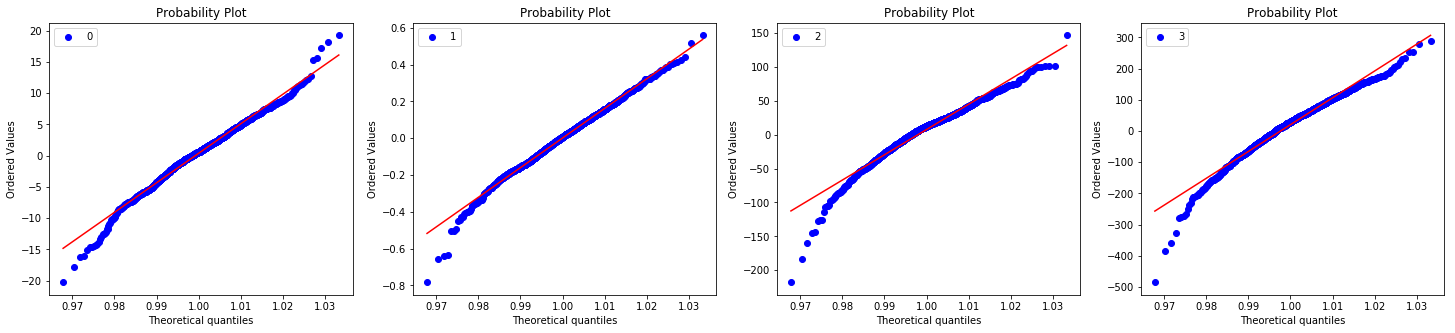

QQplot for a lognormal dist with shape parameter= 0.02 



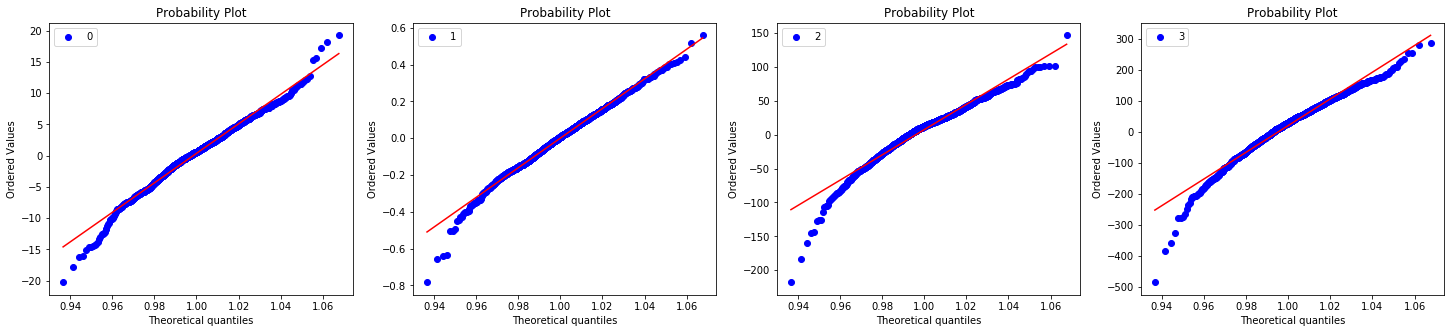

QQplot for a lognormal dist with shape parameter= 0.03 



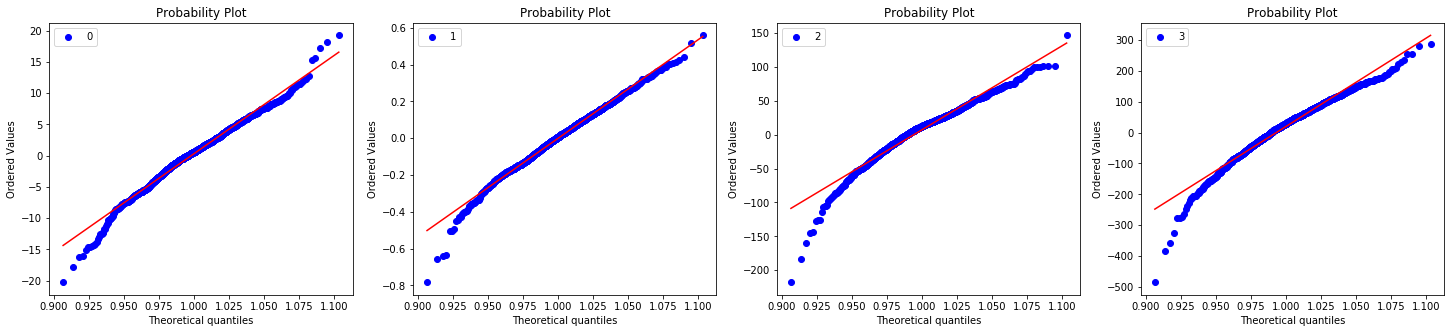

In [313]:
#comparing our factors returns to lognormal distribution by testing different shape parameters values for it 

for s in np.arange(0.01,0.04,0.01):
    #set the figure size
    fig=plt.figure(figsize=(25,5))
    print("QQplot for a lognormal dist with shape parameter=",s,"\n")
#QQplot of factor 0's returns in position 1
    QQplot(factorsReturns[0], stats.lognorm, 141, 0, shape_param=s)
#QQplot of factor 1's returns in position 2
    QQplot(factorsReturns[1], stats.lognorm, 142, 1, shape_param=s)
#QQplot of factor 2's returns in position 3
    QQplot(factorsReturns[2], stats.lognorm, 143, 2, shape_param=s)
#QQplot of factor 3's returns in position 4
    QQplot(factorsReturns[3], stats.lognorm, 144, 3, shape_param=s)

In [370]:

# RUN SILMULATION
def simulateTrialReturns_log(numTrials, factorMeans, factorCov, weights):
    trialReturns_log = []
    for i in range(0, numTrials):
        # generate sample of factors' returns
        # np.log because if x ~ lognormal; then log x ~ normal
        trialFactorReturns_log = np.log(np.random.lognormal(factorMeans, np.sqrt(factorVar)))
        
        ##===================================================================##
        # Here we either use just 1 record of the 4 samples and its done. OR:
        # Or we featurize by row; the trialFeatures
        # and maintain matrix computations
        ##===================================================================##
        
        # featurize the factors' returns
        trialFeatures_log = featurize(transpose(trialFactorReturns_log))
        
        # insert weight for intercept term
        trialFeatures_log.insert(0,1)
        
        trialTotalReturn_log = 0
        
        # calculate the return of each instrument
        # then calulate the total of return for this trial features
        trialTotalReturn_log = np.sum(np.dot(np.array(weights), np.array(trialFeatures_log)))
        
        trialReturns_log.append(trialTotalReturn_log)
    return trialReturns_log


        
parallelism = 4
numTrials = 10000
trial_indexes = list(range(0, parallelism))
seedRDD = sc.parallelize(trial_indexes, parallelism)
bFactorWeights = sc.broadcast(weights)

time0 = time()
trials_log = seedRDD.flatMap(lambda idx: \
                simulateTrialReturns_log(
                    max(int(numTrials/parallelism), 1), 
                    factorMeans, factorCov,
                    bFactorWeights.value
                ))
trials_log.cache()

valueAtRisk_log = fivePercentVaR(trials_log)
conditionalValueAtRisk_log = fivePercentCVaR(trials_log)
time1 = time()
print("Value at Risk(VaR) 5%:", valueAtRisk_log)
print("Conditional Value at Risk(CVaR) 5%:", conditionalValueAtRisk_log)
print("Time taken = ", time1 - time0)


varConfidenceInterval_log = bootstrappedConfidenceInterval(trials_log, fivePercentVaR, 100, 0.05)
cvarConfidenceInterval_log = bootstrappedConfidenceInterval(trials_log, fivePercentCVaR, 100, .05)
print("VaR confidence interval: " , varConfidenceInterval_log)
print("CVaR confidence interval: " , cvarConfidenceInterval_log)


#Density plot

#plotDistribution(trialFactorReturns_log, 144, 'Market Factor 1')
# plotDistribution(factorsReturns[1], 142, 'Market Factor 2')
# plotDistribution(factorsReturns[2], 143, 'Market Factor 3')
# plotDistribution(factorsReturns[3], 144, 'Market Factor 4')

Value at Risk(VaR) 5%: -987.0887326317292
Conditional Value at Risk(CVaR) 5%: -1353.0060188266261
Time taken =  0.49356913566589355
VaR confidence interval:  (-1024.1384237948846, -952.5581965777676)
CVaR confidence interval:  (-1402.9634736635905, -1308.1966461739205)


In [320]:
from statsmodels.nonparametric.kernel_density import KDEMultivariate
from statsmodels.nonparametric.kde import KDEUnivariate
import matplotlib.pyplot as plt
import scipy

def plot2Distributions(samples,factorsRetrurns, n, title):
    vmin = min(samples)
    vmax = max(samples)
    stddev = np.std(samples)
    
    vminF = min(factorsRetrurns)
    vmaxF = max(factorsRetrurns)
    stddevF = np.std(factorsRetrurns)
    
    domain = np.arange(vmin, vmax, (vmax-vmin)/100)
    domainF = np.arange(vminF, vmaxF, (vmaxF-vminF)/100)


    # a simple heuristic to select bandwidth
    bandwidth = 1.06 * stddev * pow(len(samples), -.2)
    bandwidthF = 1.06 * stddevF * pow(len(factorsRetrurns), -.2)


    # estimate density
    kde = KDEUnivariate(samples)
    kde.fit(bw=bandwidth)
    density = kde.evaluate(domain)
    
    kdeF = KDEUnivariate(factorsRetrurns)
    kdeF.fit(bw=bandwidthF)
    densityF = kdeF.evaluate(domainF)
    
    # plot
    
    
    plt.subplot(n)
    plt.plot(domain, density,label='samples')
    plt.plot(domainF, densityF,label='factorsRetrurns')
    plt.title(title)
    plt.xlabel('Two Week Returns ($)')
    plt.ylabel('Density')


    if n==144:
        plt.show()
        
fig=plt.figure(figsize=(20,5))

#plotDistribution(trialReturns_log,factorsReturns[0], 141, 'Market Factor 1')

# plotDistribution(factorsReturns[1], 142, 'Market Factor 2')
# plotDistribution(factorsReturns[2], 143, 'Market Factor 3')
# plotDistribution(factorsReturns[3], 144, 'Market Factor 4')

<b>QQplot for a triangular dist</b>

QQplot for a triangular dist with shape parameter= 0.5 



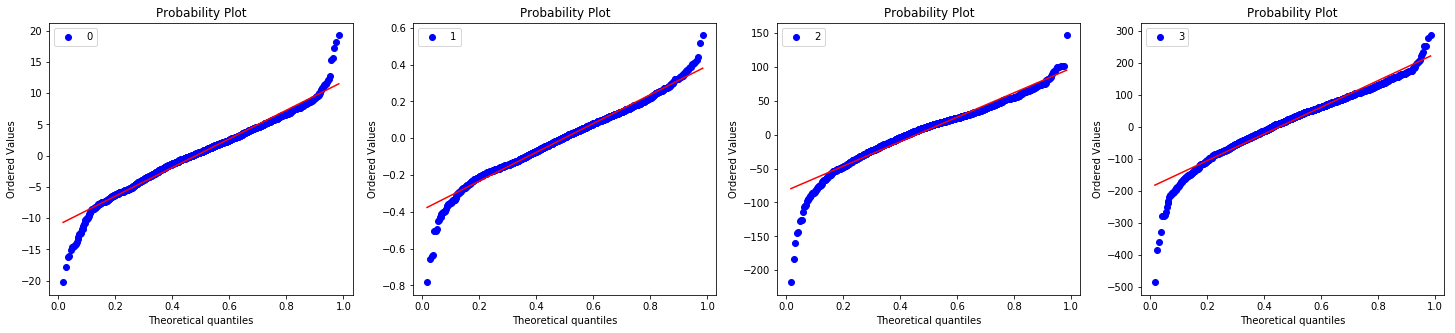

QQplot for a triangular dist with shape parameter= 0.51 



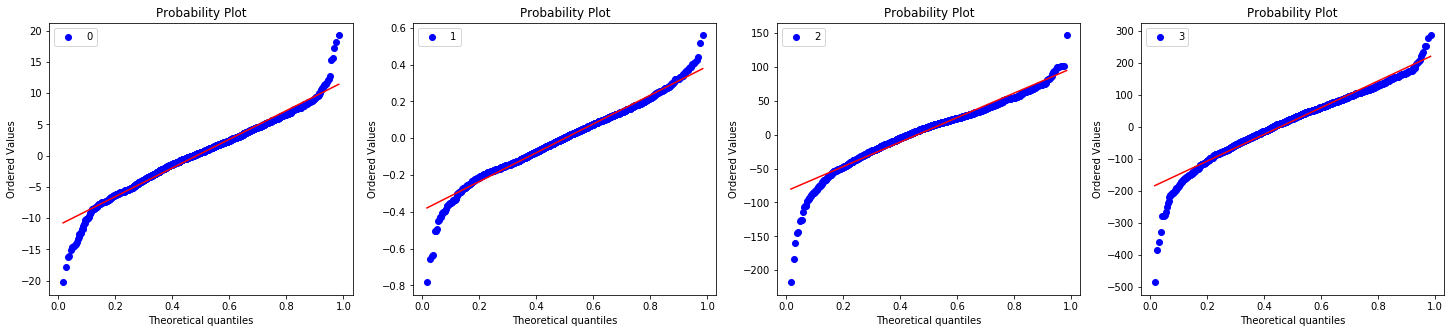

QQplot for a triangular dist with shape parameter= 0.52 



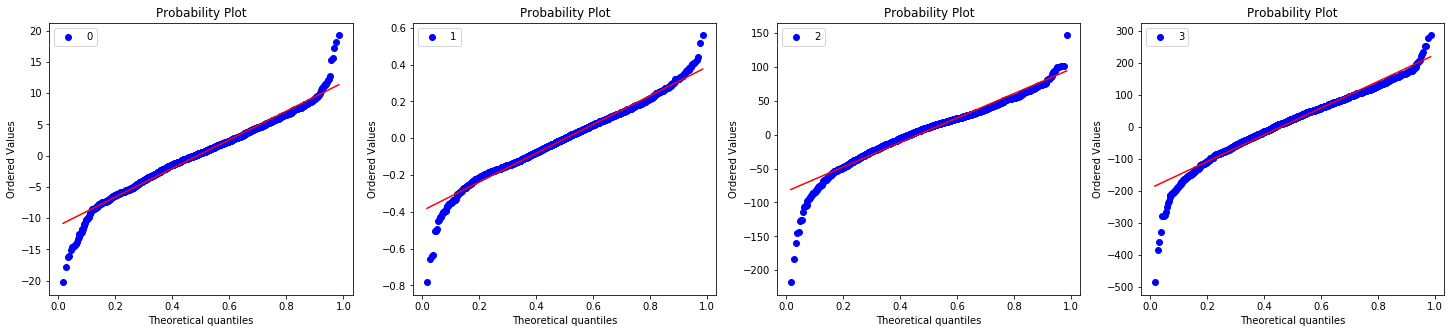

QQplot for a triangular dist with shape parameter= 0.53 



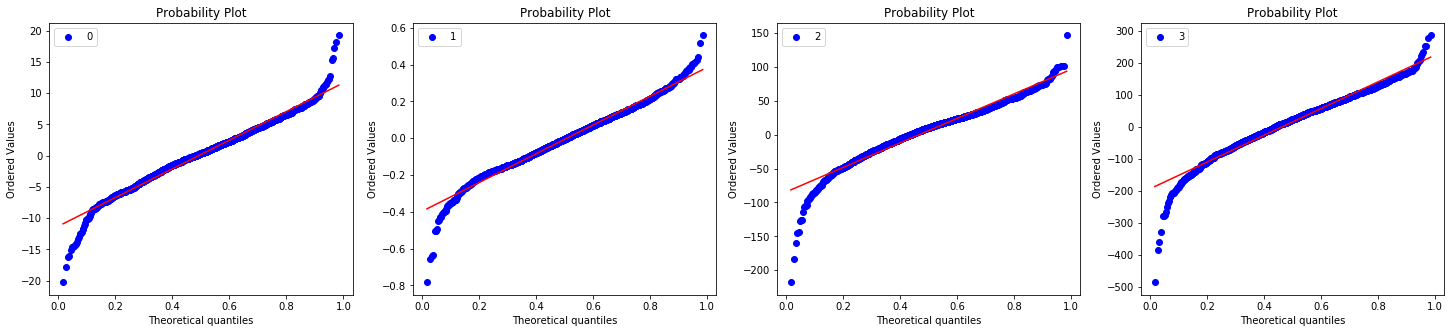

In [316]:
#comparing our factors returns to the triangular distribution by testing different shape parameters values for it 

for s in np.arange(0.5,0.53,0.01):
    #set the figure size
    fig=plt.figure(figsize=(25,5))
    print("QQplot for a triangular dist with shape parameter=",s,"\n")
    #QQplot of factor 0's returns in position 1
    QQplot(factorsReturns[0], stats.triang, 141, 0, shape_param=s)
    #QQplot of factor 1's returns in position 2
    QQplot(factorsReturns[1], stats.triang, 142, 1, shape_param=s)
    #QQplot of factor 2's returns in position 3
    QQplot(factorsReturns[2], stats.triang, 143, 2, shape_param=s)
    #QQplot of factor 3's returns in position 4
    QQplot(factorsReturns[3], stats.triang, 144, 3, shape_param=s)

In [318]:
# # RUN SILMULATION
def simulateTrialReturns_tri(numTrials, factorMeans, factorCov, weights):
    trialReturns_tri = []
    for i in range(0, numTrials):
        # generate sample of factors' returns
        trialFactorReturns_tri = np.random.triangular(factorMin, factorMeans, factorMax)
        
        ##===================================================================##
        # Here we use the factor mean as the mode because elements of factor returns are unique
        ##===================================================================##
        
        # featurize the factors' returns
        trialFeatures_tri = featurize(transpose(trialFactorReturns_tri))
        
        # insert weight for intercept term
        trialFeatures_tri.insert(0,1)
        
        trialTotalReturn_tri = 0
        
        # calculate the return of each instrument
        # then calulate the total of return for this trial features
        trialTotalReturn_tri = np.sum(np.dot(np.array(weights), np.array(trialFeatures_tri)))
        
        trialReturns_tri.append(trialTotalReturn_tri)
    return trialReturns_tri


        
parallelism = 4
numTrials = 10000
trial_indexes = list(range(0, parallelism))
seedRDD = sc.parallelize(trial_indexes, parallelism)
bFactorWeights = sc.broadcast(weights)

time0 = time()
trials_tri = seedRDD.flatMap(lambda idx: \
                simulateTrialReturns_tri(
                    max(int(numTrials/parallelism), 1), 
                    factorMeans, factorCov,
                    bFactorWeights.value
                ))
trials_tri.cache()

valueAtRisk_tri = fivePercentVaR(trials_tri)
conditionalValueAtRisk_tri = fivePercentCVaR(trials_tri)
time1 = time()
print("Value at Risk(VaR) 5%:", valueAtRisk_tri)
print("Conditional Value at Risk(CVaR) 5%:", conditionalValueAtRisk_tri)
print("Time taken = ", time1 - time0)


varConfidenceInterval_tri = bootstrappedConfidenceInterval(trials_tri, fivePercentVaR, 100, 0.05)
cvarConfidenceInterval_tri = bootstrappedConfidenceInterval(trials_tri, fivePercentCVaR, 100, .05)
print("VaR confidence interval: " , varConfidenceInterval_tri)
print("CVaR confidence interval: " , cvarConfidenceInterval_tri)
print("Kupiec test p-value: " , kupiecTestPValue(stocksReturns, valueAtRisk_tri, 0.05))


#### Density plot

#plotDistribution(trialFactorReturns_log, 144, 'Market Factor 1')
# plotDistribution(factorsReturns[1], 142, 'Market Factor 2')
# plotDistribution(factorsReturns[2], 143, 'Market Factor 3')
# plotDistribution(factorsReturns[3], 144, 'Market Factor 4')

Value at Risk(VaR) 5%: -3007.28697398189
Conditional Value at Risk(CVaR) 5%: -3974.000280045752
Time taken =  0.5904932022094727
VaR confidence interval:  (-3077.128924654337, -2879.167432184157)
CVaR confidence interval:  (-4110.9328120994705, -3860.6975656565633)
Number of failures: 41
Kupiec test p-value:  0.0012036599034810256


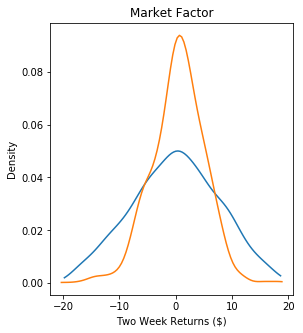

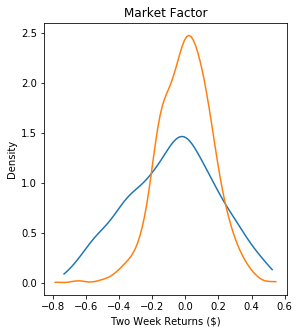

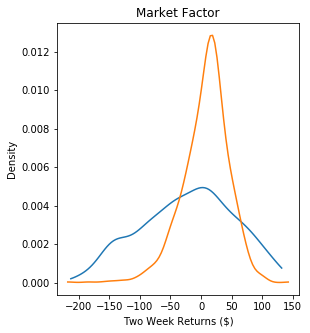

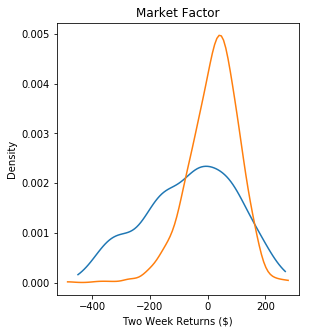

In [365]:
samples_factors_tri = []
for i in range(len(factorMin)):
    #samples_factors_uni.append(np.random.uniform(factorMin[i], factorMax[i], len(factorsReturns[0])))
    samples_factors_tri = np.random.triangular( factorMin[i], factorMeans[i], factorMax[i], len(factorsReturns[0]))
    #samples_logn = np.random.lognormal(factorMeans, np.sqrt(factorCov))[i]
    fig=plt.figure(figsize=(20,5))
    
    plot2Distributions(samples_factors_tri, factorsReturns[i], 141, 'Market Factor')


<div class='alert alert-warning'>
**EXPONENTIAL**<br>

Here we can see in the plots below that the exponential distribution does not approximate our data as well as the other distributions.
</div>

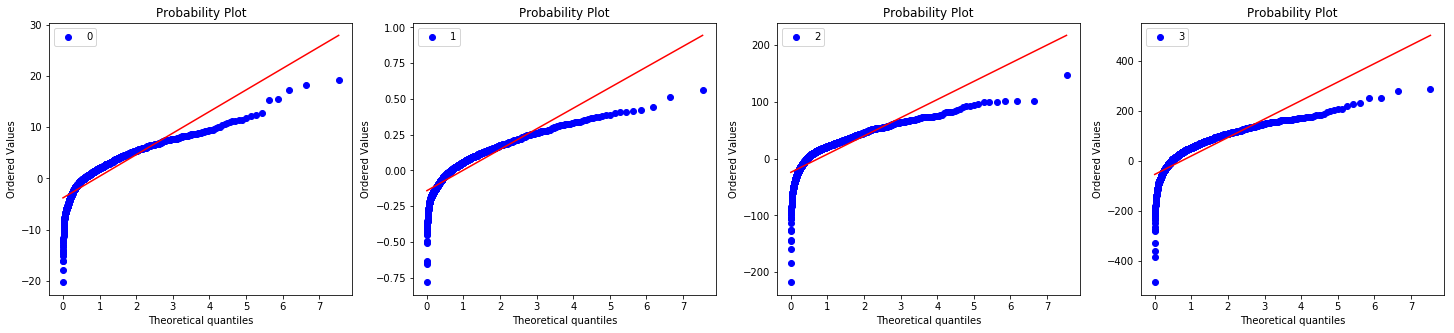

In [319]:
#comparing our factors returns to an exponential distribution 

#set the figure size
fig=plt.figure(figsize=(25,5))

#QQplot of factor 0's returns in position 1
QQplot(factorsReturns[0], stats.expon, 141, 0)
#QQplot of factor 1's returns in position 2
QQplot(factorsReturns[1], stats.expon, 142, 1)
#QQplot of factor 2's returns in position 3
QQplot(factorsReturns[2], stats.expon, 143, 2)
#QQplot of factor 3's returns in position 4
QQplot(factorsReturns[3], stats.expon, 144, 3)

In [322]:
# samples_factors_uni = []
# for i in range(len(factorMin)):
#     #samples_factors_uni.append(np.random.uniform(factorMin[i], factorMax[i], len(factorsReturns[0])))
#     #samples_tri_f1 = np.random.triangular( factorMin[i], factorMeans[i], factorMax[i], len(factorsReturns[0]))
#     samples_logn = np.random.lognormal(factorMeans, np.sqrt(factorCov))[i]
#     fig=plt.figure(figsize=(20,5))
#     plot2Distributions(samples_tri_f1, factorsReturns[i], 141, 'Market Factor 1')

# # print(len(samples_uni_f1))

# # samples = np.random.multivariate_normal(factorMeans, factorCov, len(factorsReturns[0]))
# # print(len(samples))

# # samples_tri_f1 = np.random.triangular( factorMin[0], factorMeans[0], factorMax[0], len(factorsReturns[0]))
# # print(len(samples_tri_f1))

<b>UNIFORM DISTRIBUTION</b>

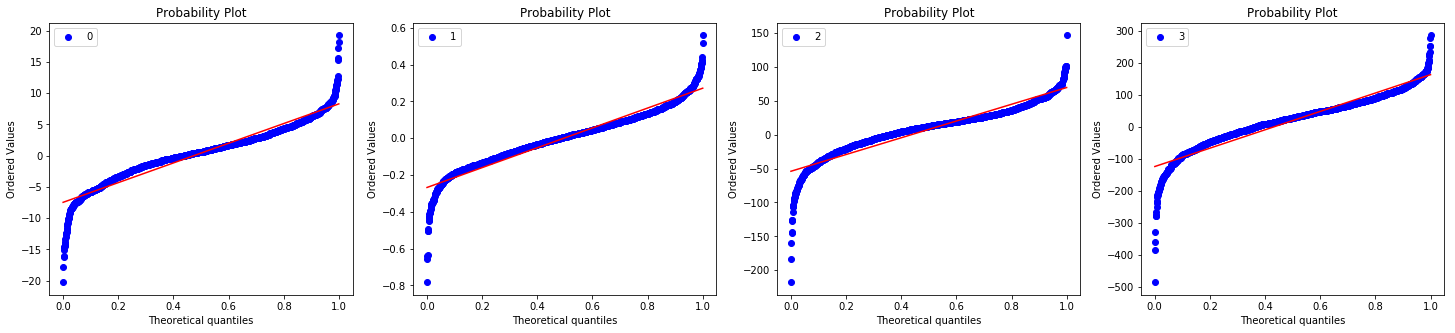

In [323]:
#comparing our factors returns to uniform distribution 

#set the figure size
fig=plt.figure(figsize=(25,5))

#QQplot of factor 0's returns in position 1
QQplot(factorsReturns[0], stats.uniform, 141, 0)
#QQplot of factor 1's returns in position 2
QQplot(factorsReturns[1], stats.uniform, 142, 1)
#QQplot of factor 2's returns in position 3
QQplot(factorsReturns[2], stats.uniform, 143, 2)
#QQplot of factor 3's returns in position 4
QQplot(factorsReturns[3], stats.uniform, 144, 3)

In [324]:
# # RUN SIMULATION
def simulateTrialReturns_uni(numTrials, factorMeans, factorCov, weights):
    trialReturns_uni = []
    for i in range(0, numTrials):
        # generate sample of factors' returns
        trialFactorReturns_uni = np.random.uniform(factorMin, factorMax)
        
        # featurize the factors' returns
        trialFeatures_uni = featurize(transpose(trialFactorReturns_uni))
        
        # insert weight for intercept term
        trialFeatures_uni.insert(0,1)
        
        trialTotalReturn_uni = 0
        
        # calculate the return of each instrument
        # then calulate the total of return for this trial features
        trialTotalReturn_uni = np.sum(np.dot(np.array(weights), np.array(trialFeatures_uni)))
        
        trialReturns_uni.append(trialTotalReturn_uni)
    return trialReturns_uni


        
parallelism = 4
numTrials = 10000
trial_indexes = list(range(0, parallelism))
seedRDD = sc.parallelize(trial_indexes, parallelism)
bFactorWeights = sc.broadcast(weights)

time0 = time()
trials_uni = seedRDD.flatMap(lambda idx: \
                simulateTrialReturns_uni(
                    max(int(numTrials/parallelism), 1), 
                    factorMeans, factorCov,
                    bFactorWeights.value
                ))
trials_uni.cache()

valueAtRisk_uni = fivePercentVaR(trials_uni)
conditionalValueAtRisk_uni = fivePercentCVaR(trials_uni)
time1 = time()
print("Value at Risk(VaR) 5%:", valueAtRisk_uni)
print("Conditional Value at Risk(CVaR) 5%:", conditionalValueAtRisk_uni)
print("Time taken = ", time1 - time0)


varConfidenceInterval_uni = bootstrappedConfidenceInterval(trials_uni, fivePercentVaR, 100, 0.05)
cvarConfidenceInterval_uni = bootstrappedConfidenceInterval(trials_uni, fivePercentCVaR, 100, .05)
print("VaR confidence interval: " , varConfidenceInterval_uni)
print("CVaR confidence interval: " , cvarConfidenceInterval_uni)
print("Kupiec test p-value: " , kupiecTestPValue(stocksReturns, valueAtRisk_uni, 0.05))


Value at Risk(VaR) 5%: -5210.8092090870905
Conditional Value at Risk(CVaR) 5%: -6607.995429305968
Time taken =  0.502509593963623
VaR confidence interval:  (-5333.720901829054, -5100.741913743946)
CVaR confidence interval:  (-6798.592399109377, -6416.89458298222)
Number of failures: 33
Kupiec test p-value:  8.478944638234279e-06


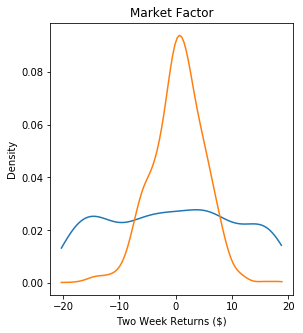

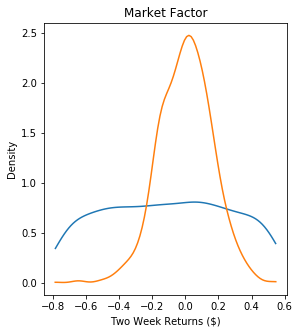

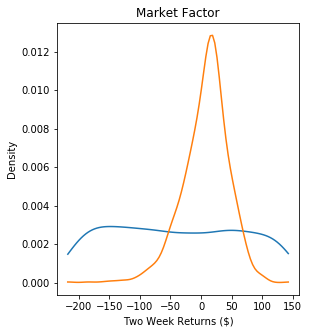

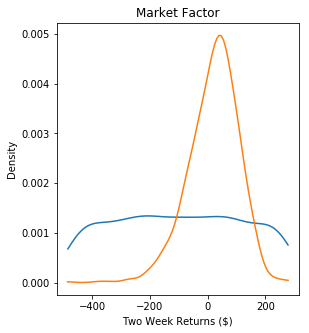

In [362]:
samples_factors_uni = []
for i in range(len(factorMin)):
    samples_factors_uni.append(np.random.uniform(factorMin[i], factorMax[i], len(factorsReturns[0])))
    #samples_tri_f1 = np.random.triangular( factorMin[i], factorMeans[i], factorMax[i], len(factorsReturns[0]))
    #samples_logn = np.random.lognormal(factorMeans, np.sqrt(factorCov))[i]
    fig=plt.figure(figsize=(20,5))
    plot2Distributions(samples_factors_uni[i], factorsReturns[i], 141, 'Market Factor')

# 6. Summary
In this lecture, we studied the Monte Carlo Simulation method and its application to estimate financial risk. To apply it, first, we needed to define the relationship between market factors and the instruments' returns. In such step, you must define the model which maps the market factors' values to the instruments' values: in our use case, we used a linear regression function for building our model. Next, we also had to find the parameters of our model, which are the weights of the factors we considered. Then, we had to study the distribution of each market factor. A good way to do that is using Kernel density estimation to smooth the distribution and plot it. Depending on the shape of each figure, we had to guess the best fit distribution for each factor: in our use case, we used a very simple approach, and decided that our smoothed distributions all looked normal distributions. 

Then, the idea of Monte Carlo simulation was to generate many possible values for each factor and calculate the corresponding outcomes by a well-defined model in each trial. After many trials, we were able to calculate VaR from the sequences of outcome's values. When the number of trials is large enough, the VaR converges to reasonable values, that we could validate using well-known statistical hypothesis. 

# References
- The example in section 2 is inspired from [this article](http://www.solver.com/monte-carlo-simulation-example).
- [Backtesting Value-at-Risk models](https://aaltodoc.aalto.fi/bitstream/handle/123456789/181/hse_ethesis_12049.pdf?sequence=1) (Kansantaloustiede, 2009) - (A good reference to study Backtesting).
